# [DM 2025/26] Phoneme Classification

💡The purpose of this project is to address the problem of the Phoneme Classification as it's proposed in one of the must-know datasets in Machine Learning: <a href="https://www.openml.org/search?type=data&sort=runs&id=1489&status=active">phoneme</a>.

The aim of this dataset is to distinguish between nasal and oral vowels. There are thus two different classes:

- Class 0 : Nasals
- Class 1 : Orals

🗣 This dataset contains vowels coming from 1809 isolated syllables (for example: pa, ta, pan,...). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. Each harmonic is signed: positive when it corresponds to a local maximum of the spectrum and negative otherwise.

Three observation moments have been kept for each vowel to obtain 5427 different instances:

- the observation corresponding to the maximum total energy Ene.

- the observations taken 8 msec before and 8 msec after the observation corresponding to this maximum total energy.

From these 5427 initial values, 23 instances for which the amplitude of the 5 first harmonics was zero were removed, leading to the 5404 instances of the present database. The patterns are presented in a random order.

📚 As first step, we import the necessary libraries for the project, we divided them according to their utility, these include:
- Machine Learning/Data Mining, 
- Data Visualization, 
- Preprocessing
- General purpose utilities

In [2]:
# Library importing

## ML
import sklearn.datasets as skl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

## Utilities
import csv
import json
import os
from typing import Any

## Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.preprocessing import MinMaxScaler, Binarizer
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# cross-validation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone

# supress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# stats
from scipy.stats import ttest_ind


c:\Users\fraca\Desktop\Universita\Applied AI\DM\phoneme_classification\DM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Dataset Analysis

📥 We then download the dataset and extract some basic information like the feature names and the unique value frequency of the classses; to have a basic idea of the structure of the data, we also display the first rows of the dataset.

In addition, we map "1" and "2" labels in 0 and 1 because some models, for instance XGBoost, cannot deal with strings as labels or prefere label values starting from 0.

In [66]:
# Dataset import
dataset = fetch_openml(name="phoneme", version=1)

# Isolating features and labels
data = dataset.data

dataset.target = dataset.target.cat.rename_categories({"1": 0, "2": 1})
labels = dataset.target

# Getting label counts
label_counts = np.unique_counts(labels)

# Taking feature names and label names
feature_names = dataset.feature_names
feature_names


['V1', 'V2', 'V3', 'V4', 'V5']

The dataset has 5 features as specified in the description, they are all real numbers, so they can be considered as belonging to the **ratio** category.

In [67]:
data.head()

V1        V2        V3        V4        V5
0  0.489927 -0.451528 -1.047990 -0.598693 -0.020418
1 -0.641265  0.109245  0.292130 -0.916804  0.240223
2  0.870593 -0.459862  0.578159  0.806634  0.835248
3 -0.628439 -0.316284  1.934295 -1.427099 -0.136583
4 -0.596399  0.015938  2.043206 -1.688448 -0.948127

⚖️ Counting the unique values of the classes, we discover that the class ratio is 70% - 30%, this suggests high imbalancing so, in the following analysis will be foundamental to considerate balancing strategies to mitigate the problem.

In [68]:
labels.value_counts() / labels.value_counts().sum()


Class
0    0.706514
1    0.293486
Name: count, dtype: float64

📜 With the `describe()` method we can visualize a dataframe with all the basic statistics of the dataset. In particular we observe that all the features have mean = 0 (with reasonable approximation) and standard deviation = 1 meaning that they are **already standardized** and don't need any additional scaling.

In [6]:
# Extracting statistics on data
data.describe()

V1            V2            V3            V4            V5
count  5.404000e+03  5.404000e+03  5.404000e+03  5.404000e+03  5.404000e+03
mean   3.330866e-09  5.551443e-09  6.106588e-09 -9.437454e-09 -6.698742e-08
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -2.933743e+00 -3.038709e+00 -2.795869e+00 -2.485340e+00 -2.367461e+00
25%   -6.697555e-01 -7.790800e-01 -9.505788e-01 -7.583255e-01 -5.405418e-01
50%   -3.801605e-01 -2.150985e-01 -3.861800e-02 -1.422555e-01 -2.127475e-01
75%    3.149040e-01  7.136990e-01  7.771393e-01  6.759035e-01  2.045420e-01
max    3.828575e+00  3.664763e+00  2.630868e+00  3.046948e+00  4.586666e+00

📈 To better visualize the inner structure of the dataset we render 3 plots:
- A group of **boxplots** each representing the distribution of a feature, as they are standard scaled we do not expect any relevant difference on the position or on the variability, however some variation can be observed.
- A **barplot** showing the class distribution; it highlights the imbalance between class 1 and 2
- A **parallel coordinates plot** that gives us more insight on the structure of the features. The class imbalance is also visible from this perspective as the blue lines almost cover the orange ones.

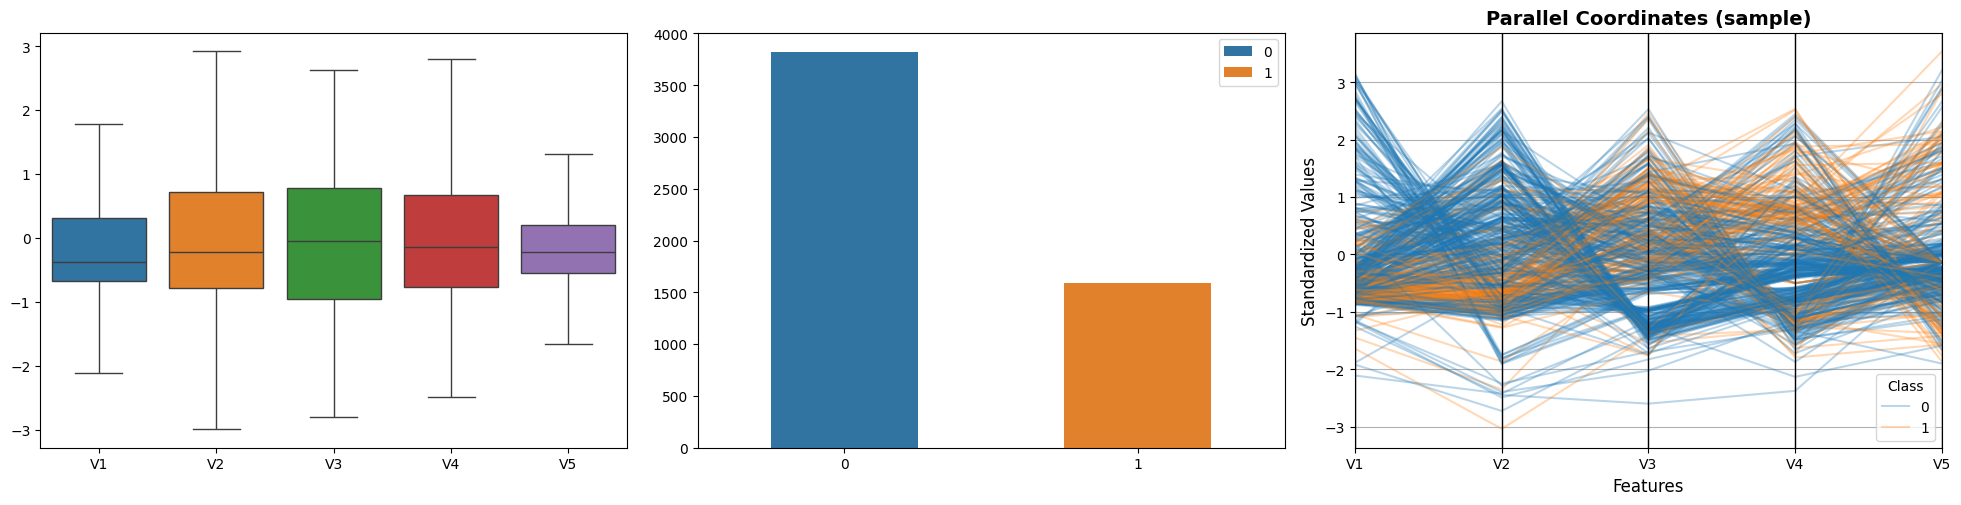

In [69]:
# Creating 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=2)

# Boxplot -> feature distribution 
sns.boxplot(data, 
            palette="tab10", 
            showfliers=False, 
            ax=axs[0]
            )

# Barplot -> class distribution
sns.barplot(x=label_counts.values, 
            y=label_counts.counts, 
            palette="tab10", 
            hue=label_counts.values, 
            legend=True,
            width=0.5, 
            ax=axs[1]
			)

# Building a temporary dataframe with information about classes (necessary for parallel coordinates)
df = data.copy()
df["class"] = labels

# Campiona per rendere il grafico leggibile
df_sample = df.sample(n=min(500, len(df)), random_state=42)

parallel_coordinates(
    frame=df_sample,  # Usa campione
    class_column="class",
    color=sns.color_palette("tab10", n_colors=2),
    ax=axs[2],
    alpha=0.3  # Trasparenza per vedere meglio
)
axs[2].set_title("Parallel Coordinates (sample)", fontsize=14, fontweight='bold')
axs[2].set_xlabel("Features", fontsize=12)
axs[2].set_ylabel("Standardized Values", fontsize=12)
axs[2].legend(title='Class', loc='best')
plt.show()

🔗 To investigate on the **feature correlation** we calculate a correlation matrix and plot it as a heatmap. We notice that each feature have a very weak pairwise correlation with each other, almost scoring zero. This aspect suggests that perhaps, as it happened for the scaling, the data we have is already been pre-processed in a earlier stage.

To further improve our understanding on data, we also plotted
- Five couples of **violin plots**, with the $i$-th couple providing insight about how the $i$-th feature is distributed for both the classes.
- A **scatter matrix** that shows a scatter-plot for each couple of features and gives us a visual confirm about the extremely low correlation between each couple of features.

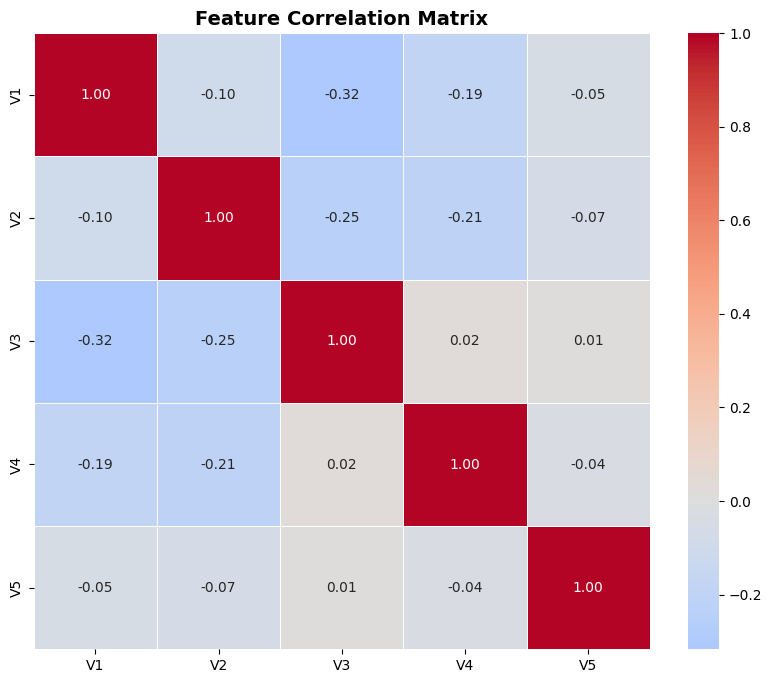

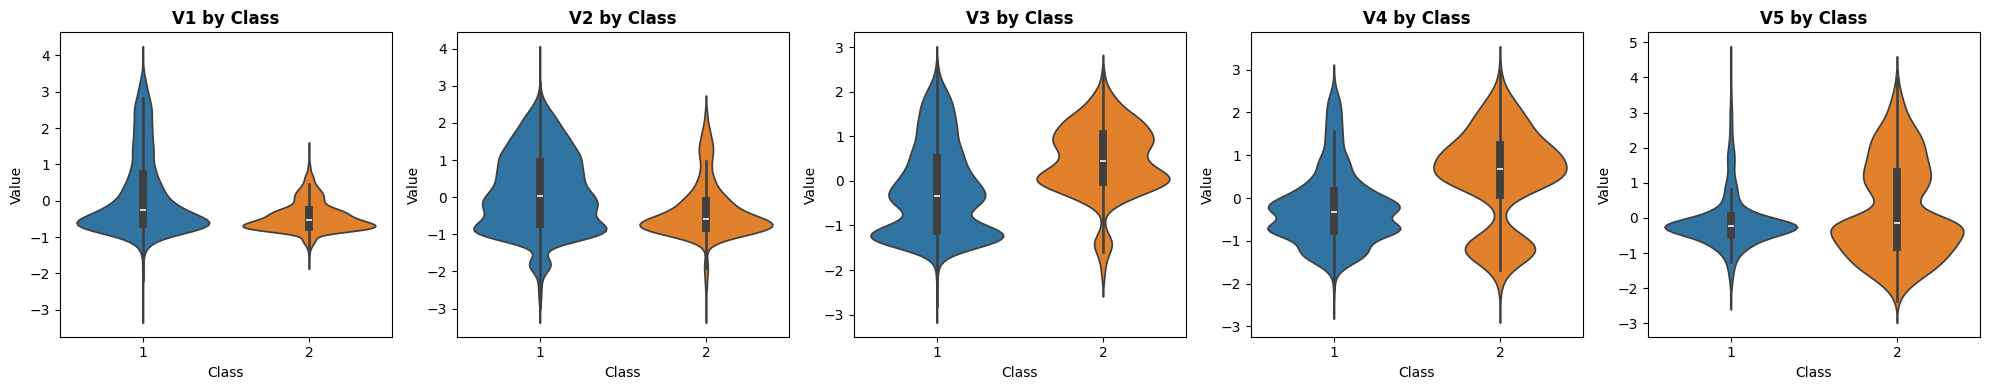

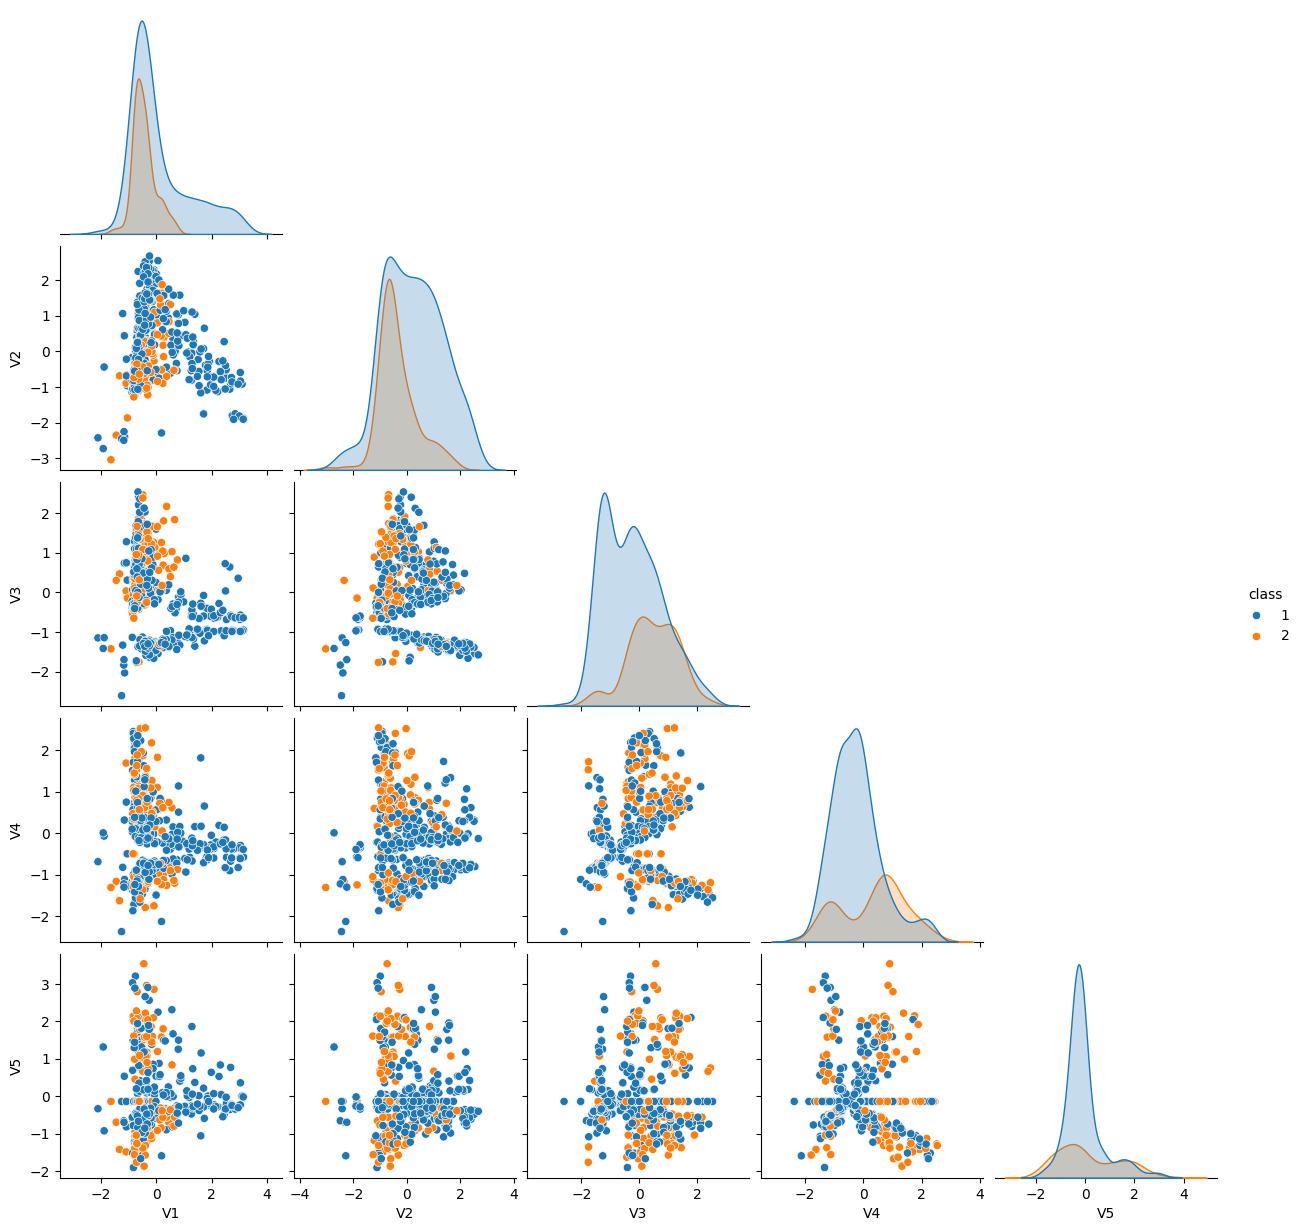

In [8]:
#  CORRELAZIONE TRA FEATURES
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

# DISTRIBUZIONE PER CLASSE (violin plot)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, col in enumerate(data.columns):
    df_plot = data.copy()
    df_plot['class'] = labels
    sns.violinplot(data=df_plot, 
                   x='class', 
                   y=col, 
                   hue='class',  
                   palette='tab10', 
                   legend=False,  
                   ax=axes[idx])
    axes[idx].set_title(f'{col} by Class', fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Value')
plt.tight_layout()
plt.show()

#PAIRPLOT 
df_sample = data.sample(n=500, random_state=42).copy()
df_sample['class'] = labels[df_sample.index]
sns.pairplot(df_sample, hue='class', palette='tab10', diag_kind='kde', corner=True)
plt.show()

## 2. Preprocessing

⏳ Once we obtained a clear idea of how our data looks like, the next step is to preprocess it aiming to make it suitable for the elaboration with Data Mining models.

First se set some constants that will be useful in the continuation of our study

In [9]:
# Preprocessing variables
RANDOM_SEED = 42	# To enable riproducibility of our experiments
TRAIN_SIZE = 0.75	# To set the percentage of data that will be used for training our models

### 2.1 Missing values handling

🛑 To detect missing values on our data, we create a dataframe containing information about NA (not available) istances with the `is_na()` method, then we render a description of this dataset, and we discover that **there is no missing data**, so there is no need to think of operations to manage it.

In [10]:
data.isna().describe()

V1     V2     V3     V4     V5
count    5404   5404   5404   5404   5404
unique      1      1      1      1      1
top     False  False  False  False  False
freq     5404   5404   5404   5404   5404

### 2.2 Train-Test split

✂️ At this point we perform train test split according to the TRAIN_SIZE variable we set above. We set the `stratify` argument such a way that a stratified sampling is performed and the class proportion is the same both in the train and in the test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=TRAIN_SIZE, stratify=labels, random_state=RANDOM_SEED)

y_train = y_train.cat.rename_categories({"1": 0, "2": 1})
y_test = y_test.cat.rename_categories({"1": 0, "2": 1})

np.unique_counts(y_test); np.unique_counts(y_train)

UniqueCountsResult(values=array([0, 1]), counts=array([2863, 1190]))

After the set is split we save all the partitions in csv format so that we can use them in the other notebook, **hyperparameter_tuning** where we perform hyperparameter tuning for our models.

In [12]:
X_train.to_csv("data/X_train.csv", sep=",", index=False)
X_test.to_csv("data/X_test.csv", sep=",", index=False)
y_train.to_csv("data/y_train.csv", sep=",", index=False)
y_test.to_csv("data/y_test.csv", sep=",", index=False)

### 2.3 Balancing

Given that our dataset is highly unbalanced, there are two possible rebalancing approaches: undersampling and oversampling.
We choose to explore both these approaches to determine which of these best improves the model performances.

We perform the balancing after the train test split only on the train set because both the techniques, if applied to the entire dataset, would cause data leakage since they modify the training set distribution based on the knowledge of the test set one, and we must always assume that we don't know anything about the test set.

⬇️ For the undersampling approach we use the class `RandomUnderSampler` and we obtain that both the classes have the dimension of the smaller one.

In [13]:
under_sampler = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
np.unique_counts(y_train_under)

UniqueCountsResult(values=array([0, 1]), counts=array([1190, 1190]))

And se save the obtained datasets

In [14]:
X_train_under.to_csv("data/X_train_under.csv", sep=",", index=False)
y_train_under.to_csv("data/y_train_under.csv", sep=",", index=False)

⬆️ For the oversampling approach we use the class `ADASYN` (see documentation <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html">here</a>) and we obtain that both the classes have the dimension of the larger one.

In [15]:
over_sampler = ADASYN(random_state=RANDOM_SEED)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
# y_train_over = y_train_over.cat.rename_categories({"1": 0, "2": 1})

np.unique_counts(y_train_over)

UniqueCountsResult(values=array([0, 1]), counts=array([2863, 2908]))

And se save the obtained datasets

In [16]:
X_train_over.to_csv("data/X_train_over.csv", sep=",", index=False)
y_train_over.to_csv("data/y_train_over.csv", sep=",", index=False)

### 2.3 Reduction

In order to visualize our data in a 2D scatter plot, we need to reduce its dimensionality; to do this we explore 3 strategies: PCA, LDA and t-SNE.

#### 2.3.1 PCA reduction

⭐ As first feature extraction approach we use PCA, an unsupervised method that produces as output the principal components of our data. In order to plot data we choose as dimension 2 then we perform the transformation. Of course, to avoid data leakage, we fit the reductor only with train data then we transform the test data. Otherwise the reduction parameters would have contained some information about test data and we want to avoid this.

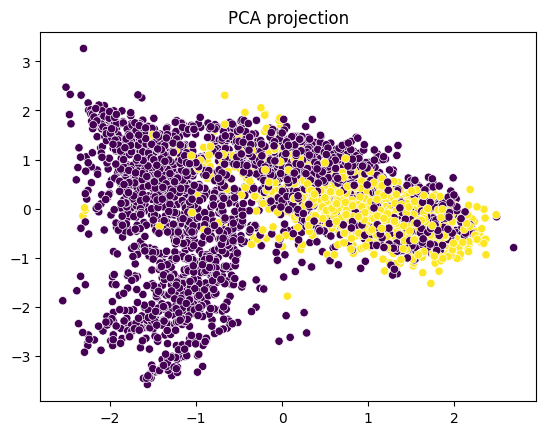

((4053, 2), (1351, 2))

In [17]:
pca_reductor = PCA(n_components=2, random_state=RANDOM_SEED)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_pca = pca_reductor.fit_transform(X_train)

# Transforming test data with reductor fitted on train data
X_test_pca = pca_reductor.transform(X_test)

pca_plot = sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:,1], c=y_train.values.astype(int))
pca_plot.set_title("PCA projection")
plt.show()

X_train_pca.shape, X_test_pca.shape

#### 2.3.2 LDA reduction

📐 As second approach we perform a LDA transformation, a supervised method to reduce data dimensionality (in fact the `fit_transform` method requires the labels `y_train` as parameter).
For the same reason as before, we fit the reductor on the train set and then perform the transformation on the test set.
While for the PCA the number of components had the only constraint to be less or equal than the number of features, for LDA it must be less or equal to $min(\#features, \#classes-1)$ for our case less or equal than 1. Since we don't had much possibility to choose, we set `n_components` to 1 and plot the projection to a 1-D space.

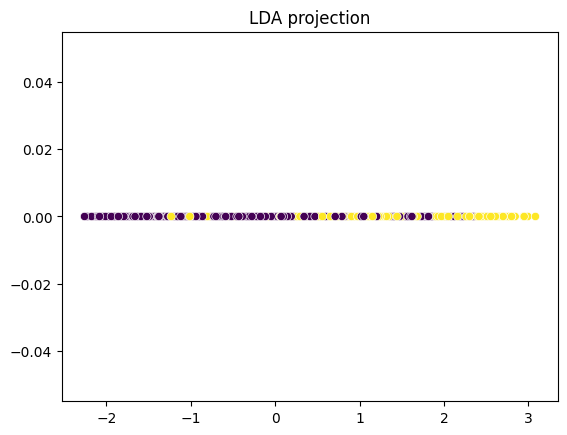

((4053, 1), (1351, 1))

In [18]:
lda_reductor = LDA(n_components=1)	# n_components cannot be larger than min(n_features, n_classes - 1) = min(5, 1)

# Fitting PCA reductor ONLY with train data to avoid data leakage
X_train_lda = lda_reductor.fit_transform(X_train, y_train)

# Transforming test data with reductor fitted on train data
X_test_lda = lda_reductor.transform(X_test)

lda_plot = sns.scatterplot(x=X_train_lda[:, 0], y=np.zeros(shape=X_train_lda.shape[0]), c=y_train.values.astype(int))
lda_plot.set_title("LDA projection")
plt.show()

X_train_lda.shape, X_test_lda.shape

#### 2.3.3 t-SNE reduction

🗺️ The last reduction approach we propose is t-SNE, since this is only aimed to visualization and we will never use data reduced with t-SNE to fit our models, we can reduce all the dataset without caring about data leakage. The parameter configuration we used is the default. 

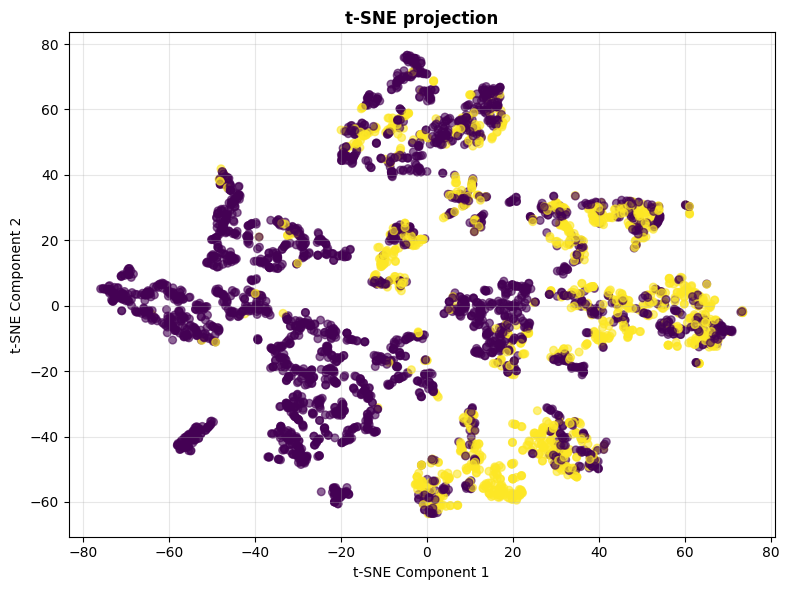

X_train_tsne shape: (4053, 2)


In [19]:
tsne_reductor = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)

X_train_tsne = tsne_reductor.fit_transform(X_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], 
                      c=y_train.values.astype(int), alpha=0.6, s=30)
plt.title('t-SNE projection', fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"X_train_tsne shape: {X_train_tsne.shape}")

## 3. Classification

🤖 After dataset analisys, cleaning and preprocessing, we are ready to perform our classification task. We decided to compare the performances of the most popular and widespread classifiers.

First we consider a group of shallow models including:
- A Decision Tree
- A Naive Bayes
- A k-Nearest Neighboor
- Three SVCs: one trained with original 5D data, one with PCA-reduced data and one with UMAP reduced data (see documentation <a href="https://umap-learn.readthedocs.io/en/latest/">here</a>)
- A Multi-Layer Perceptron
- A Random Forest
- An AdaBoost
- An Extreme Gradient Boosting


In [20]:
models_base = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=RANDOM_SEED, probability=True),
    "SVC_PCA": SVC(probability=True, random_state=42), # SVC with PCA preprocessing
    "SVC_UMAP": SVC(probability=True, random_state=42), # SVC with UMAP preprocessing
    "MLP": MLPClassifier(random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_SEED),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(),
}

🛠️ In order to obtain best performances, we also designed a **custom ensemble model**. When it is istanciated, we specify a list of single models (as many as we want) whose predicted probabilities will be averaged to compute the predicted probabilities of the ensemble model. Our aim is to investigate wheter the aggregated predicted probabilities can be more precise and robuts compared to the ones performed by single models.

The probabilities are computed according tho the following logic.

$P_i = [p_{i1}, p_{i2}, ..., p_{in}]$ are the probabilities predicted by model $i$ for records $1, ..., n$; with $m$ models, $i$ goes from 1 to $m$
$$
P_{custom} = \frac{1}{m}\sum_{i=1}^{m} P_i
$$

In [ ]:
class EnsembleClassifier:
	def __init__(self, model_names: list):
		self.model_names = model_names
		self.ensemble_models = {}
		for name in model_names:
			self.ensemble_models[name] = models_base[name]
		
	def fit(self, X_train, y_train):
		for model_name, model_istance in self.ensemble_models.items():
			model_istance.fit(X_train, y_train)  

	# Using "Soft Voting" as voting policy
	def predict(self, X_test):
		self.y_proba_agg = np.zeros(shape=(y_test.shape[0],))
		for model_name, model_istance in self.ensemble_models.items():
			self.y_proba_agg += model_istance.predict_proba(X_test)[:, 1]
		self.y_proba_agg /= len(self.ensemble_models.keys())
		return self.y_proba_agg.round()
	
	def predict_proba(self, X_test):
		return self.y_proba_agg
		

ensemble = EnsembleClassifier(["SVC", "XGBoost", "AdaBoost"])
models_base["CustomEnsemble"] = ensemble

🧠 We also added to our comparison a convolutive neural network based on Conv1D layers. This kind of networks are particularly effective on detect patterns on linear data with convolutional operations.

As we did for the ensemble classifier, we wrapped the network in a class having `fit`, `predict`, and `predict_proba` methods so that we can uniform all the operations to the ones we perform with the models provided by the Scikit-Learn API. We designed the class so that the user can build the network in a very customizable way, by specifying the following parameters:
- `n_conv_layers` is the number of Conv1D layers stacked one after the other
- `n_filters_in_layers` is a list where the $i$-th item is the number of convolutive filters for the $i$-th layer
- `kernel_size` is the linear dimension of the filters (for simplicity we assumed that every layer has the same kernel dimension)
- `dense_layer_units` is a list where the $i$-th item is the number of output units of the $i$-th dense layer
- `optimizer` specifies the optimization strategy that the network will use (the most used are adam, RMSprop, adagrad, adadelta)
- `loss` specifies the loss function that the model will optimize during the training phase and binary cross entropy is the standard for binary classification tasks
- `metrics` is a list of metrics that are evaluated during the training and validation phases

In [22]:
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D

class DeepConvolutionalModel:
	def __init__(self, n_conv_layers=2, 
			  n_filters_in_layers=[32, 16], 
			  kernel_size=2, 
			  dense_layer_units=[10],
			  optimizer="RMSprop",
			  loss="binary_crossentropy",
			  metrics=["accuracy"]):
		assert n_conv_layers > 0
		assert n_conv_layers == len(n_filters_in_layers)

		initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_SEED)

		# Building the Convolutional Neural network
		layers = [Conv1D(filters=n_filters_in_layers[0], kernel_size=kernel_size, activation='relu', input_shape=(5, 1), padding="same", kernel_initializer=initializer)]
		for i in range(n_conv_layers):
			layers.append(Conv1D(filters=n_filters_in_layers[i], kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer=initializer))
		layers.append(GlobalAveragePooling1D())
		for i in range(len(dense_layer_units)):
			layers.append(Dense(dense_layer_units[i], activation='relu', kernel_initializer=initializer))
		layers.append(Dense(1, activation="sigmoid", kernel_initializer=initializer))

		# Instanciating the model
		self.model = Sequential(layers)
		self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


	def fit(self, X_train, y_train, epochs=30, batch_size=32, validation_split=0.2):
		self.X_train_tensor = X_train.to_numpy(dtype=np.float32)[..., np.newaxis]
		self.X_test_tensor = X_test.to_numpy(dtype=np.float32)[..., np.newaxis]
		self.y_train_tensor = y_train.to_numpy()
		self.y_test_tensor = y_test.to_numpy()

		history = self.model.fit(
			self.X_train_tensor,
			self.y_train_tensor,
			epochs=epochs,
			batch_size=batch_size,
			validation_split=validation_split,
			verbose=0
		)

	def predict(self, X_test):
		self.probs = self.model.predict(self.X_test_tensor)
		return self.probs.round()

	def predict_proba(self, X_test):
		return self.probs
	
convNetwork = DeepConvolutionalModel()
models_base["DeepConvModel"] = convNetwork

For each model we consider in the comparison, we will run training and evaluation in three different setups: without balancing, with undersampling and with oversampling.

In [23]:
import copy
models = {
    name: {
        sampling: copy.deepcopy(model) 
        for sampling in ["over", "under", "none"]
    } 
    for name, model in models_base.items()
}

configs = {
	'none': (X_train, y_train),
	'over': (X_train_over, y_train_over),
	'under': (X_train_under, y_train_under)
}

# Heatmap and Roc curve render functions require a different color name specification
colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}

🌯 To uniform the train and the evaluation processes of our models we define a routine. Apart from wrapping the classic `fit` and `predict` methods it manages some particular training instances such as:
- The convolutional network and the custom ensemble, whose methods `predict_proba` return an array with a single column, not with 2 columns as the Scikit-Learn models.
- Two istances of the SVC model that we train with PCA-reduced (according to the project guidelines) and UMAP-reduced data.

The routine outputs a series of metrics that will be used in the comparison section, then the results are saved into json files.

In [24]:
# Defining a function that, given a model, returns the results of its training
# Revised to include PCA/UMAP preprocessing for specific models
def compute_results(model_name: str, **train_config):
    results = {}  
    
    needs_pca = ("SVC_PCA",)
    needs_umap = ("SVC_UMAP",)
    
    for idx, (strategy, (X_tr, y_tr)) in enumerate(train_config.items()):
        model = models[model_name][strategy]
        
        # Preprocessing in base al modello
        if model_name in needs_pca:
            pca = PCA(n_components=2)
            X_tr_processed = pca.fit_transform(X_tr)
            X_te_processed = pca.transform(X_test)
            
        elif model_name in needs_umap:
            umap = UMAP(n_components=2, random_state=RANDOM_SEED)
            X_tr_processed = umap.fit_transform(X_tr, y=y_tr)  # Supervisionato
            X_te_processed = umap.transform(X_test)
            
        else:
            X_tr_processed = X_tr
            X_te_processed = X_test
        
        model.fit(X_tr_processed, y_tr)    
        
        y_pred = model.predict(X_te_processed)
        
        if model_name in ("CustomEnsemble", "DeepConvModel"):
            y_pred_proba = model.predict_proba(X_te_processed)
        else:
            y_pred_proba = model.predict_proba(X_te_processed)[:, 1]
        
        results[strategy] = {
            'model': model,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan, 
            'feature_importances': model.feature_importances_ if model_name in ("DecisionTree", "RandomForest", "AdaBoost", "XGBoost") else None,
            'X_train_processed': X_tr_processed,
            'X_test_processed': X_te_processed
        }
        
        # Salva reducer dentro la strategia
        if model_name in needs_pca:
            results[strategy]['pca'] = pca
        if model_name in needs_umap:
            results[strategy]['umap'] = umap

        with open(f"results/{model_name}_{strategy}.json", mode="w") as file:
            report_with_auc = classification_report(y_test, results[strategy]["y_pred"], output_dict=True)
            report_with_auc["ROC-AUC"] = results[strategy]["ROC-AUC"]
            json.dump(report_with_auc, file, indent="\t")
    
    return results

📊 In addition, we define a function to render the plots for each model, in particular we will plot:
- Three confusion matrices (one for each balancing setup) for each model
- Three ROC curves (one for each balancing setup) for each model
- A barplot representing the feature importance for each tree-based model (DecisionTree, RandomForest, AdaBoost, XGBoost)
- The tree structure for the decision tree
- Three mesh grids (one for each balancing setup) to represent the decision boundaries of the SVCs trained with PCA-reduced and UMAP-reduced data

In [25]:
from sklearn.preprocessing import LabelEncoder
# Defining a function that, given a model, renders plots for its results
# Revised to include PCA decision boundary rendering for specific models
def render_plots(model_name: str, results: dict, colors: dict):
    if model_name == "DecisionTree":
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        fig.suptitle('Decision Tree Structures (max depth=3)', fontsize=16, y=0.98)

        for idx, strategy in enumerate(configs.keys()):
            model = results[strategy]['model']
            plot_tree(model, 
                      feature_names=dataset.feature_names,
                      class_names=['Classe 0', 'Classe 1'],  
                      filled=True, 
                      max_depth=3,
                      fontsize=8,
                      ax=axes[idx])
            axes[idx].set_title(f'{strategy.capitalize()}', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

    if model_name in ("SVC_PCA", "SVC_UMAP"):   
        le = LabelEncoder()
        y_test_numeric = le.fit_transform(y_test)
        cm_colors = {'none': 'Blues', 'over': 'Greens', 'under': 'Oranges'}
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('SVM - Decision Boundaries', 
                     fontsize=16, fontweight='bold', y=1.02)

        for idx, strategy in enumerate(['none', 'over', 'under']):
            ax = axes[idx]
            
            X_train_pca = results[strategy]['X_train_processed']
            X_test_pca = results[strategy]['X_test_processed']
            model = results[strategy]['model']
            
            y_train_numeric = le.transform(configs[strategy][1])
            
            # Crea mesh grid
            h = 0.02
            x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
            y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
            
            # Predici su mesh (usa il modello già addestrato su 2D)
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = le.transform(Z)
            Z = Z.reshape(xx.shape)
            
            # Plot
            ax.contourf(xx, yy, Z, alpha=0.3, cmap=cm_colors[strategy])
            ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                      c=y_test_numeric, cmap=cm_colors[strategy], 
                      edgecolors='black', s=50, alpha=0.7)
            
            ax.set_title(f'{strategy.capitalize()}\nAccuracy: {results[strategy]["accuracy"]:.3f}', fontweight='bold')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component' if idx == 0 else '')
            ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Render Confusion Matrix
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for idx, strategy in enumerate(results.keys()):
        cm = confusion_matrix(y_test, results[strategy]["y_pred"])
        sns.heatmap(cm, annot=True, cmap=colors[strategy], fmt="d", ax=axes[idx], cbar=True)
        axes[idx].set_title(f'{strategy.capitalize()}\nAccuracy: {results[strategy]["accuracy"]:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True' if idx == 0 else '')

    plt.tight_layout()
    plt.show()

    # Render ROC curve
    plt.figure(figsize=(10, 7))
    for strategy in results.keys():
        y_pred_proba = results[strategy]['y_pred_proba']
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        roc_colors = {k: v.lower()[:-1] for (k, v) in colors.items()}	
        plt.plot(fpr, tpr, color=roc_colors[strategy], lw=2, 
                label=f'{strategy.capitalize()} (AUC = {roc_auc:.3f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name} Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Render Feature importance
    if model_name in ("DecisionTree", "RandomForest", "AdaBoost", "XGBoost"):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for idx, strategy in enumerate(results.keys()):
            feature_importance = pd.DataFrame({
                'feature': data.columns,
                'importance': results[strategy]["feature_importances"]
            }).sort_values('importance', ascending=False)

            sns.barplot(data=feature_importance, 
                        x='importance', 
                        y='feature',
                        hue='feature',  
                        palette='viridis',
                        legend=False,
                        ax=axes[idx])
            
            for p in axes[idx].patches:
                width = p.get_width()
                y = p.get_y() + p.get_height() / 2

                axes[idx].text(
                    width - 0.01 * axes[idx].get_xlim()[1],
                    y,
                    f'{width:.3f}',
                    ha='right',
                    va='center',
                    color='white',
                    fontsize=9
                )

            axes[idx].set_title(f'{strategy.capitalize()}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel("Importance", fontsize=10)
            axes[idx].set_ylabel("Features" if idx == 0 else "", fontsize=10)
        
        plt.tight_layout()
        plt.show()

🎛️ In order to achieve the best possible performances from our models, we need to select good **hyperparameters** for them. 

The hyperparameter tuning is a crucial step of the validation phase in the Data Mining process and it consists on searching hyperparameter combinations that maximize the model performances. More details on the hyperparameters tunig will be provided in the **hyperparameter_tuning** notebook.

In [26]:
# Importing the file of the tuned iperparameters
with open("./tuned_hyperparameters.json", mode="r") as file:
    hyperparameters = json.load(file)

for model in models.keys():
    for sampling in ("over", "under", "none"):
        if model in ("DeepConvModel",): 
            continue
        elif model == "CustomEnsemble":
            for shallow_model_name in models["CustomEnsemble"][sampling].model_names:
                models.get("CustomEnsemble").get(sampling).ensemble_models[shallow_model_name].set_params(**hyperparameters.get(sampling).get(shallow_model_name).get("params"))
        elif model in ("SVC_PCA", "SVC_UMAP"):
            pass # No hyperparameter tuning for SVC_PCA/SVC_UMAP
        else:
            models.get(model).get(sampling).set_params(**hyperparameters.get(sampling).get(model).get("params"))

### 3.1 Shallow Machine Learning

In this section, for each of our models, we perform training and evaluation with the `compute_results` function and then we render the plots to visualize these results with the `render_plots` function.

We create a dictionary to save the results for each model in or

#### 3.1.1 Decision Tree

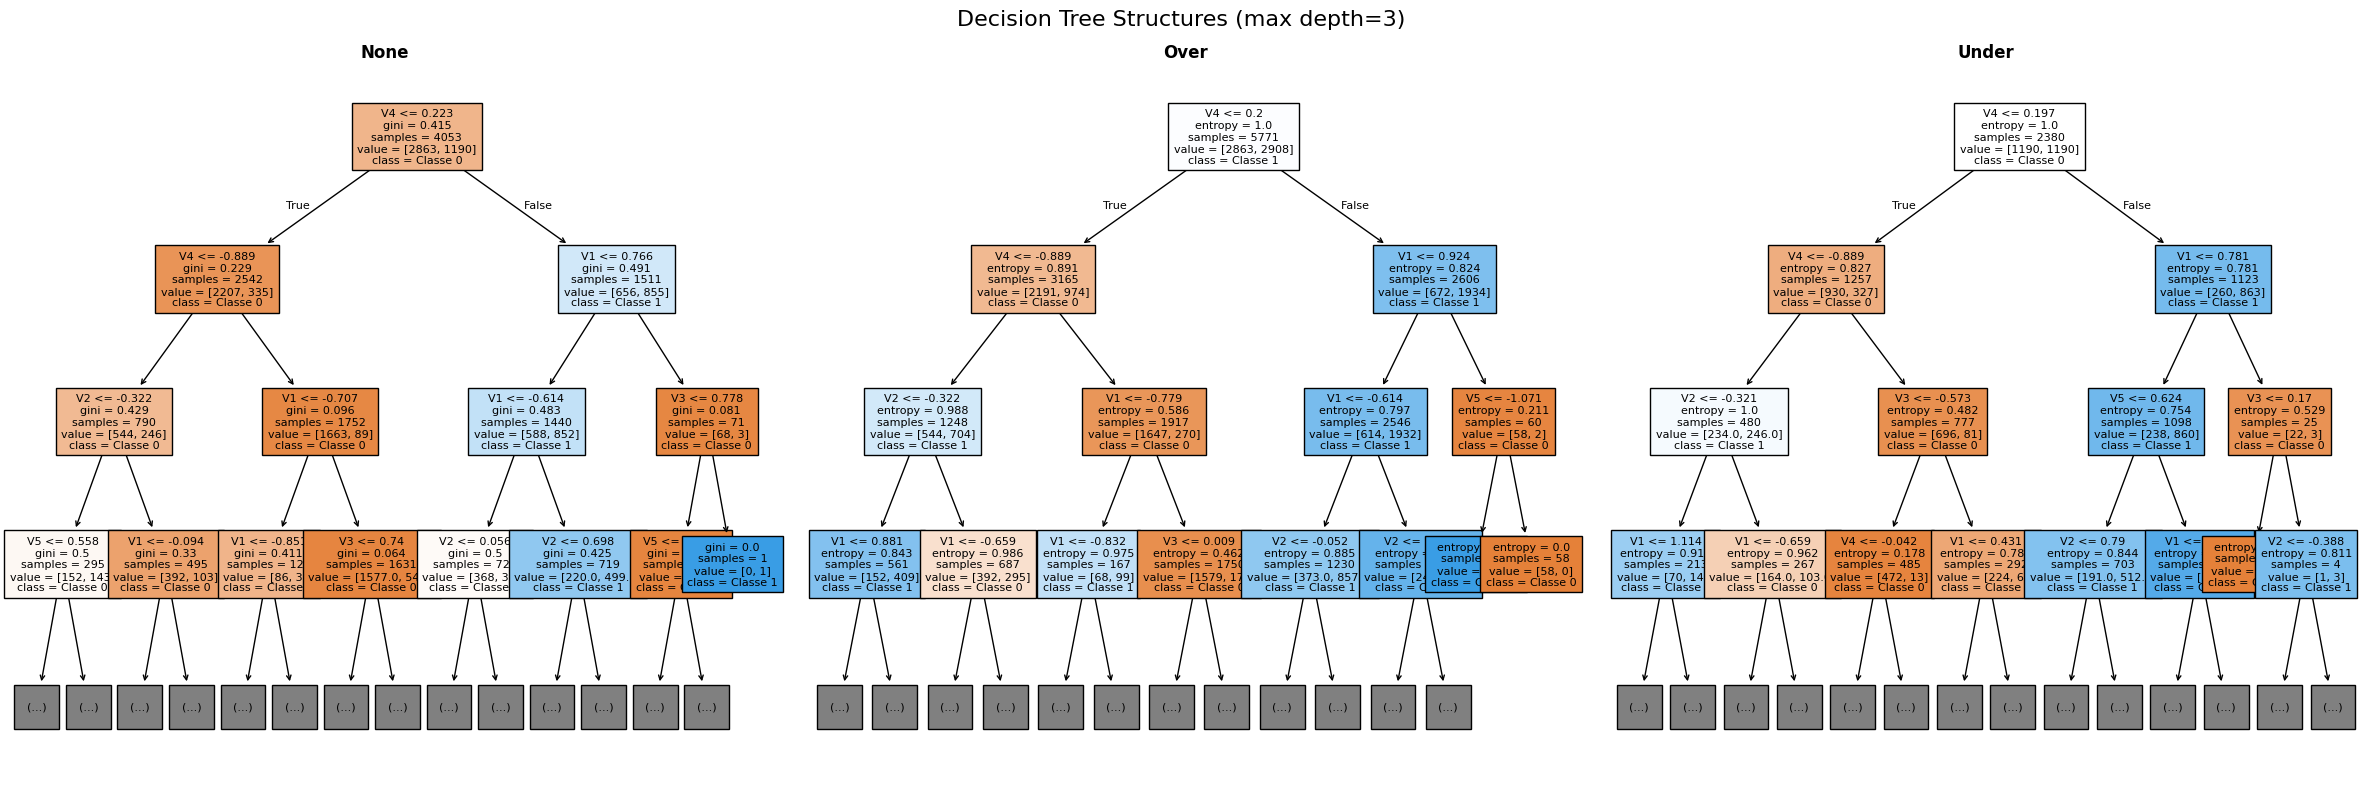

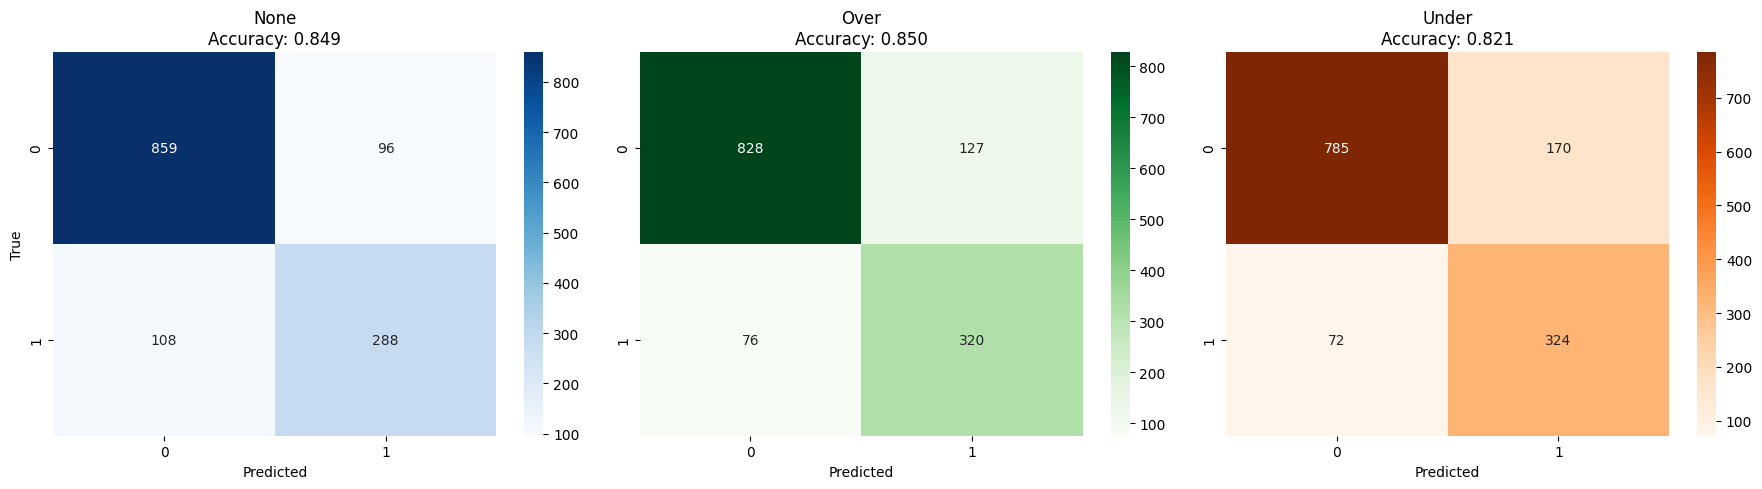

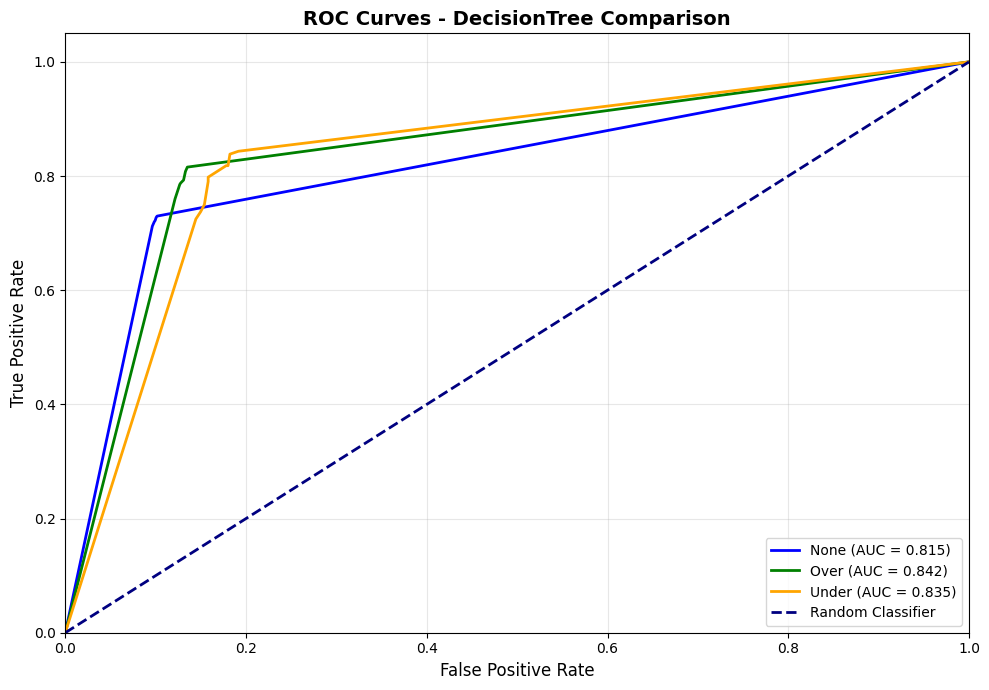

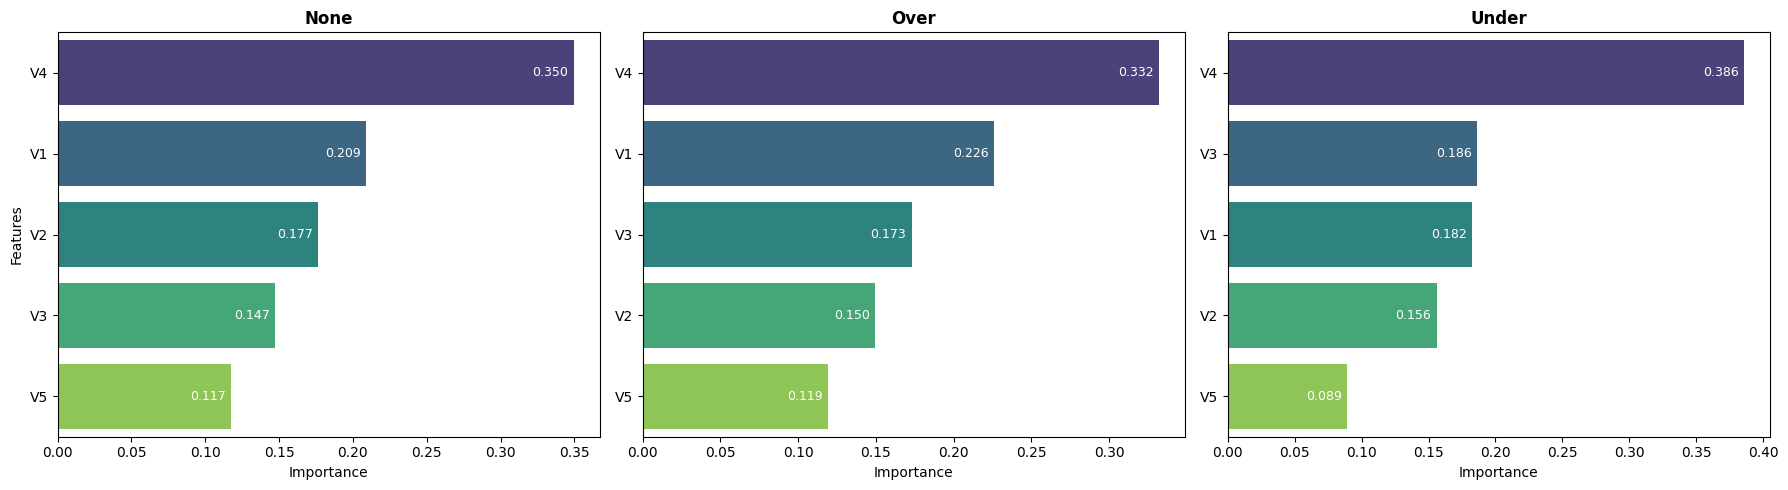

In [28]:
results = compute_results("DecisionTree", **configs)
render_plots("DecisionTree", results, colors)

#### 3.1.2 Naive Bayes

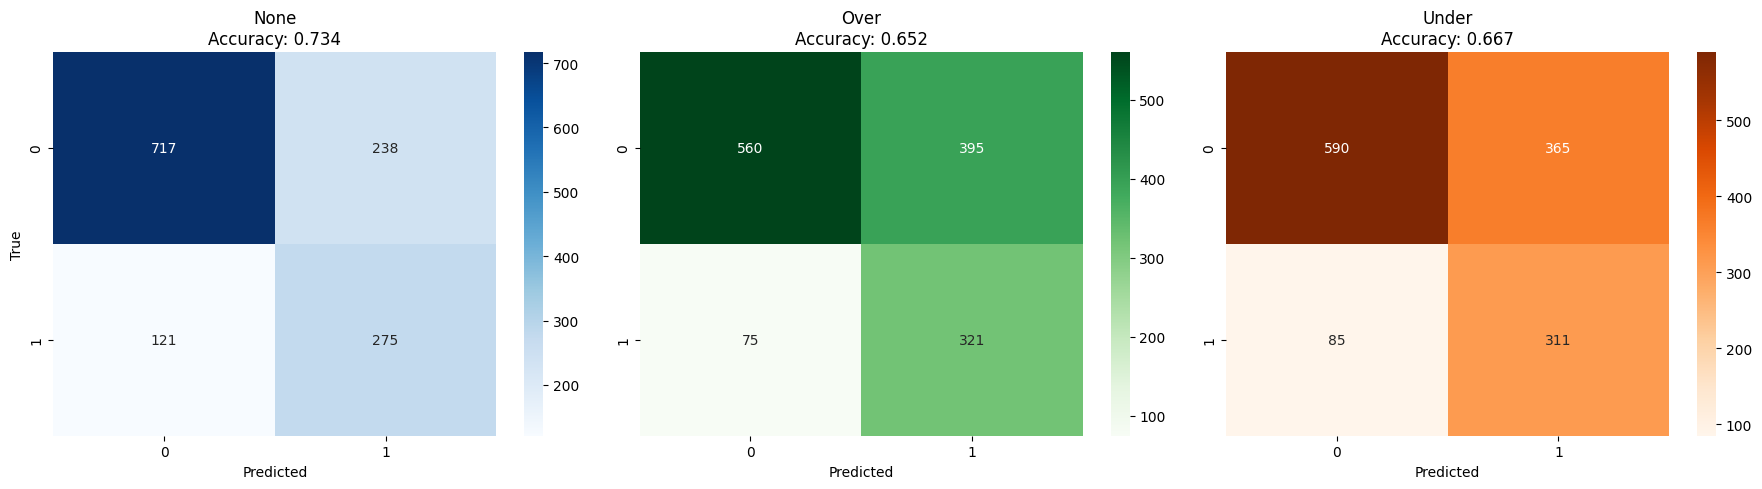

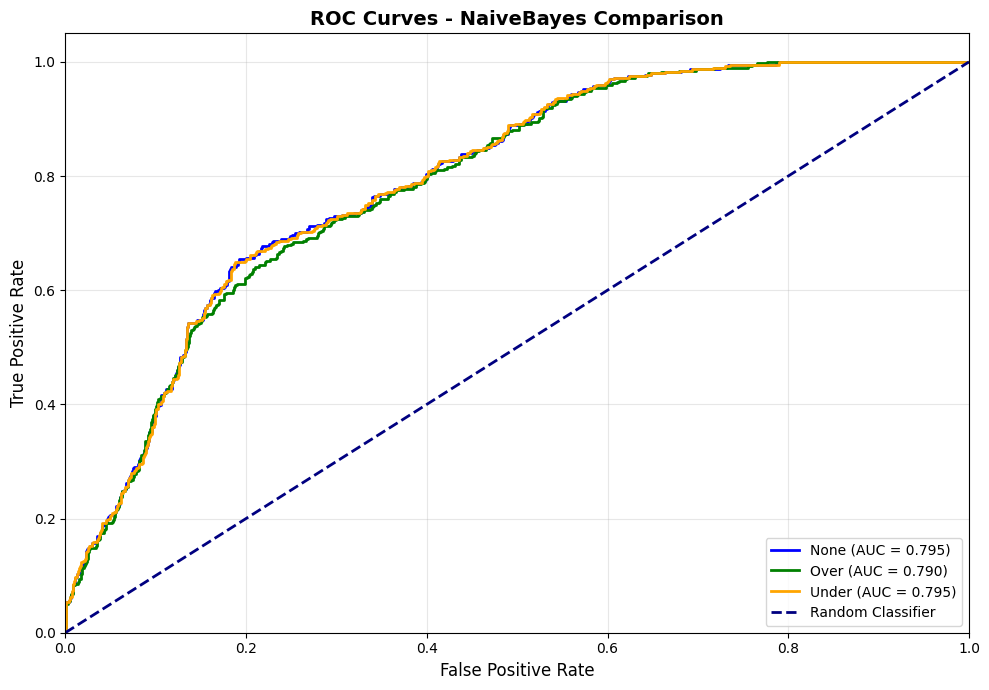

In [29]:
results = compute_results("NaiveBayes", **configs)
render_plots("NaiveBayes", results, colors)

#### 3.1.3 KNN Classifier

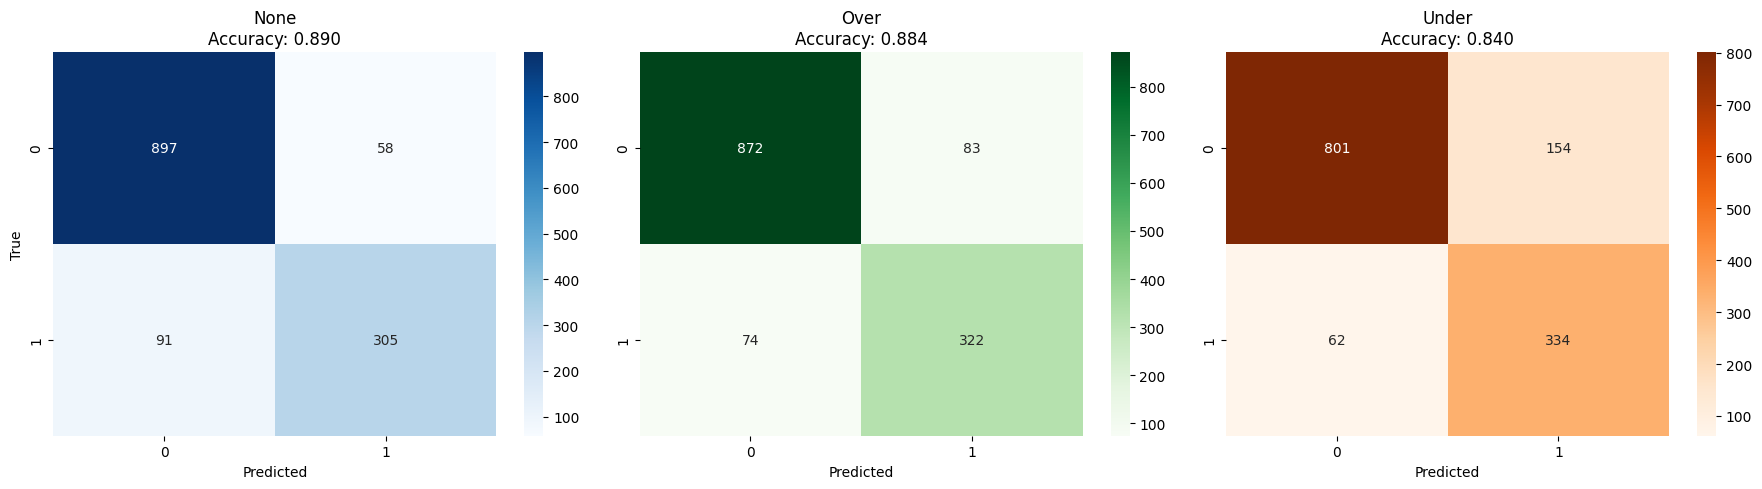

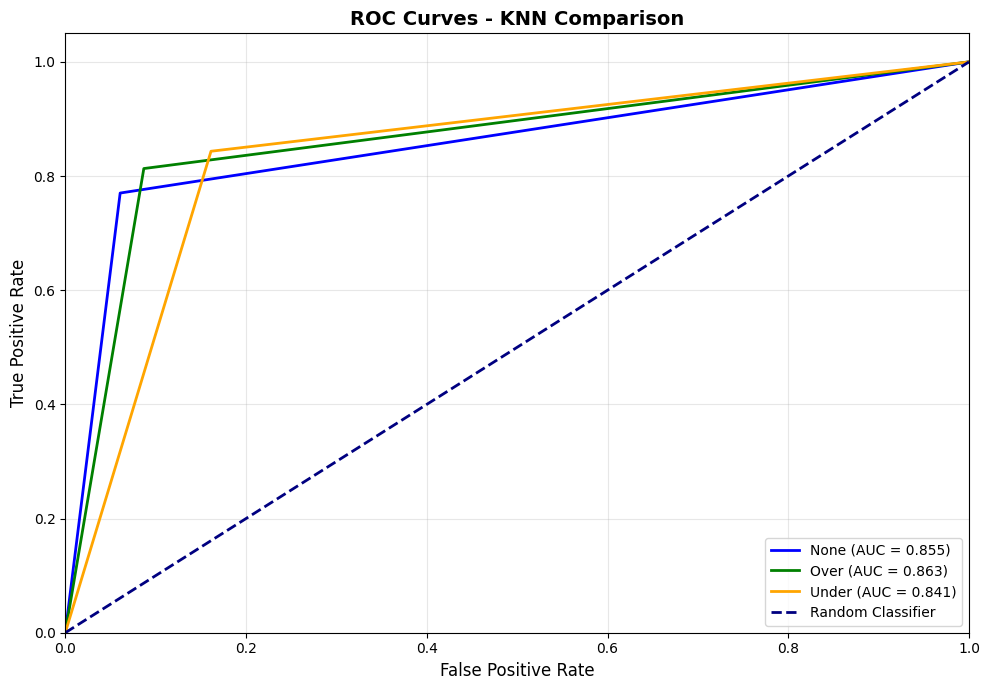

In [30]:
results = compute_results("KNN", **configs)
render_plots("KNN", results, colors)

#### 3.1.4 SVM Classifier

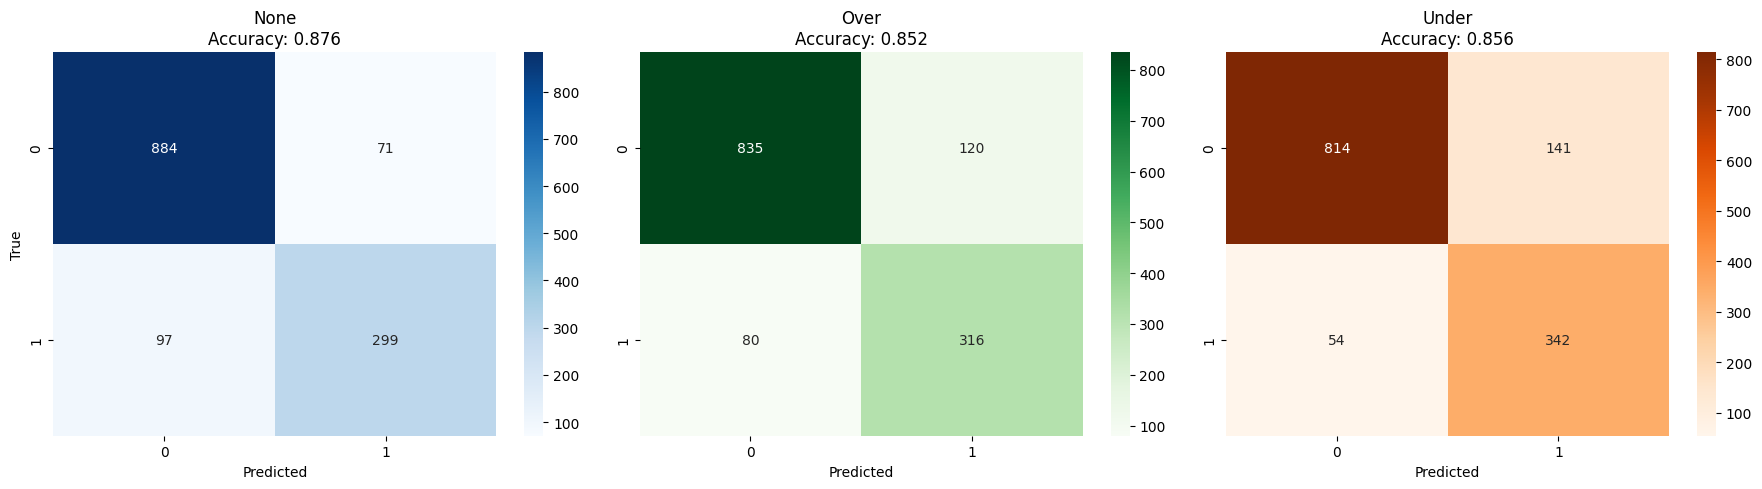

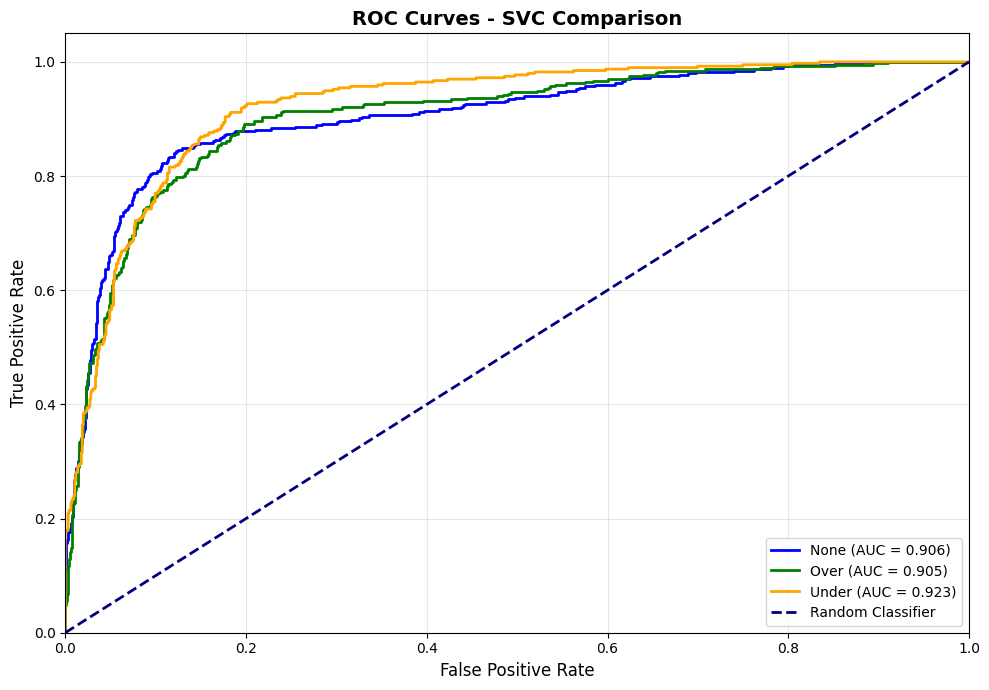

In [31]:
results = compute_results("SVC", **configs)
render_plots("SVC", results, colors)

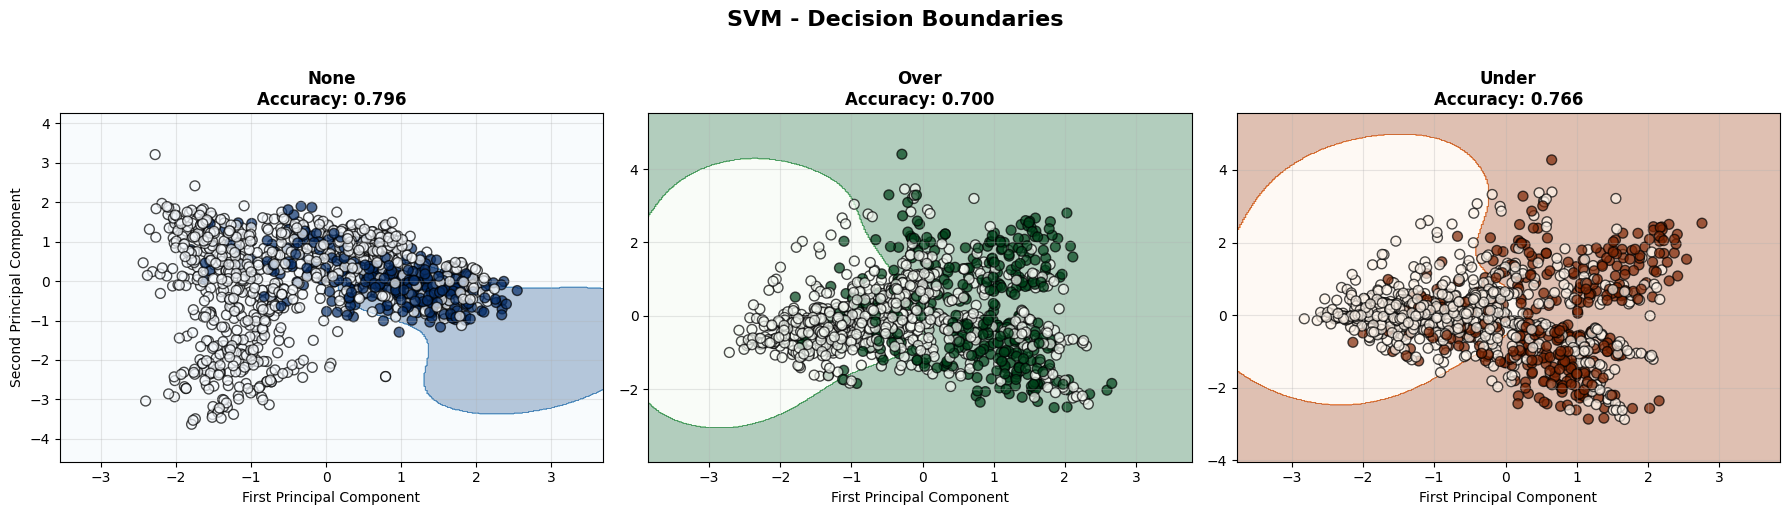

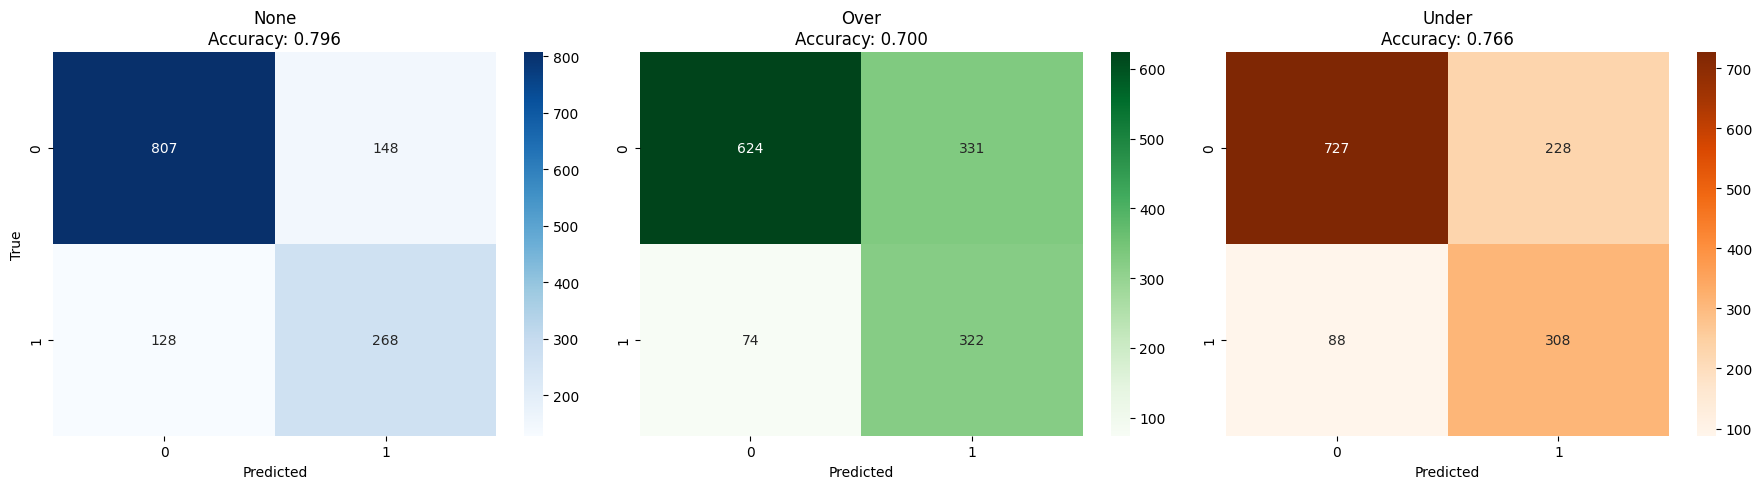

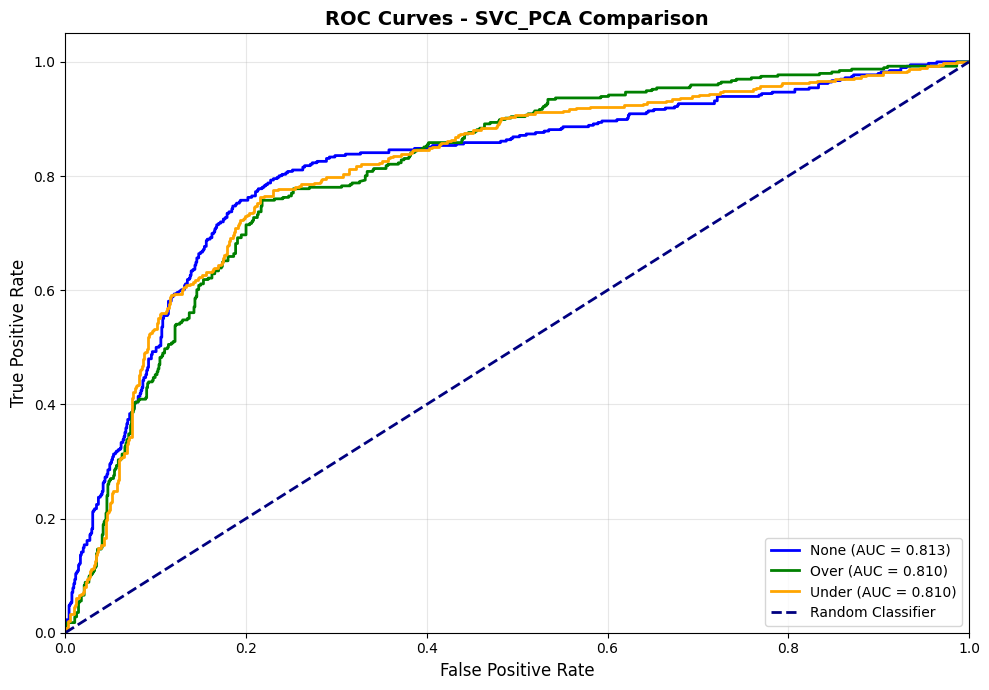

In [32]:
# SVM PCA decision boundaries rendering
results_svc_pca = compute_results("SVC_PCA", **configs)
render_plots("SVC_PCA", results_svc_pca, colors)

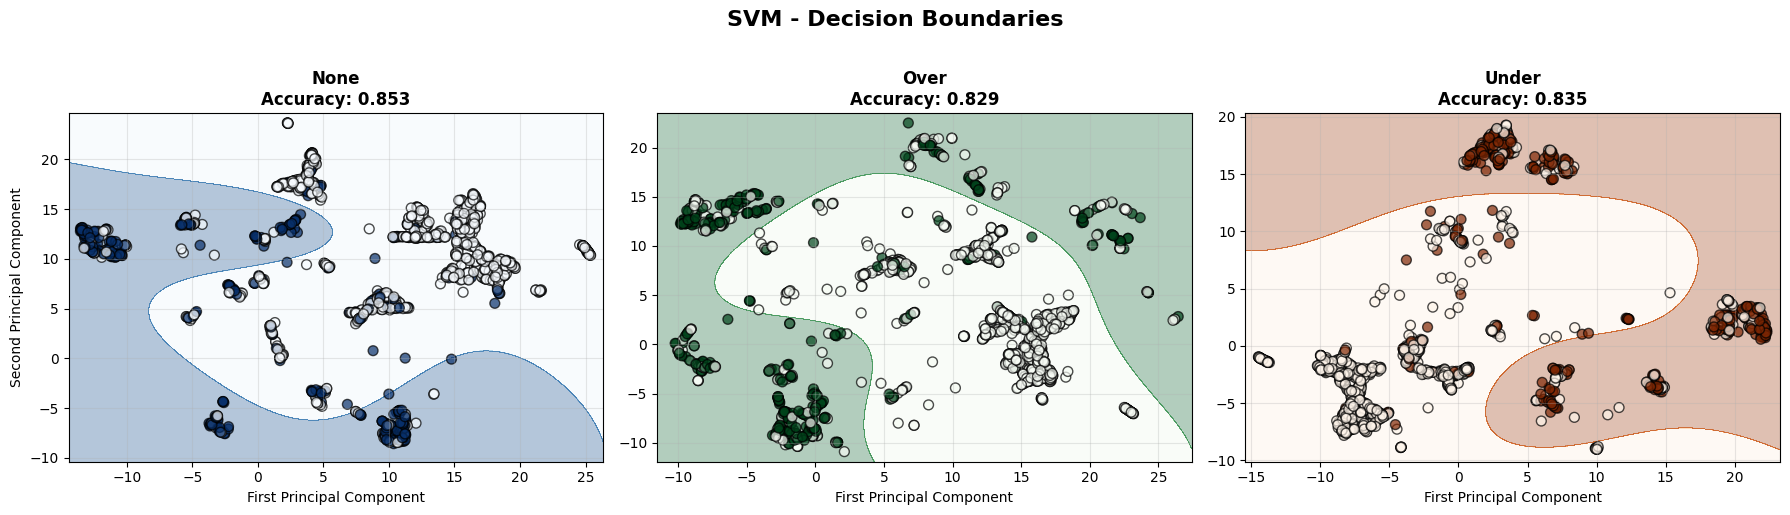

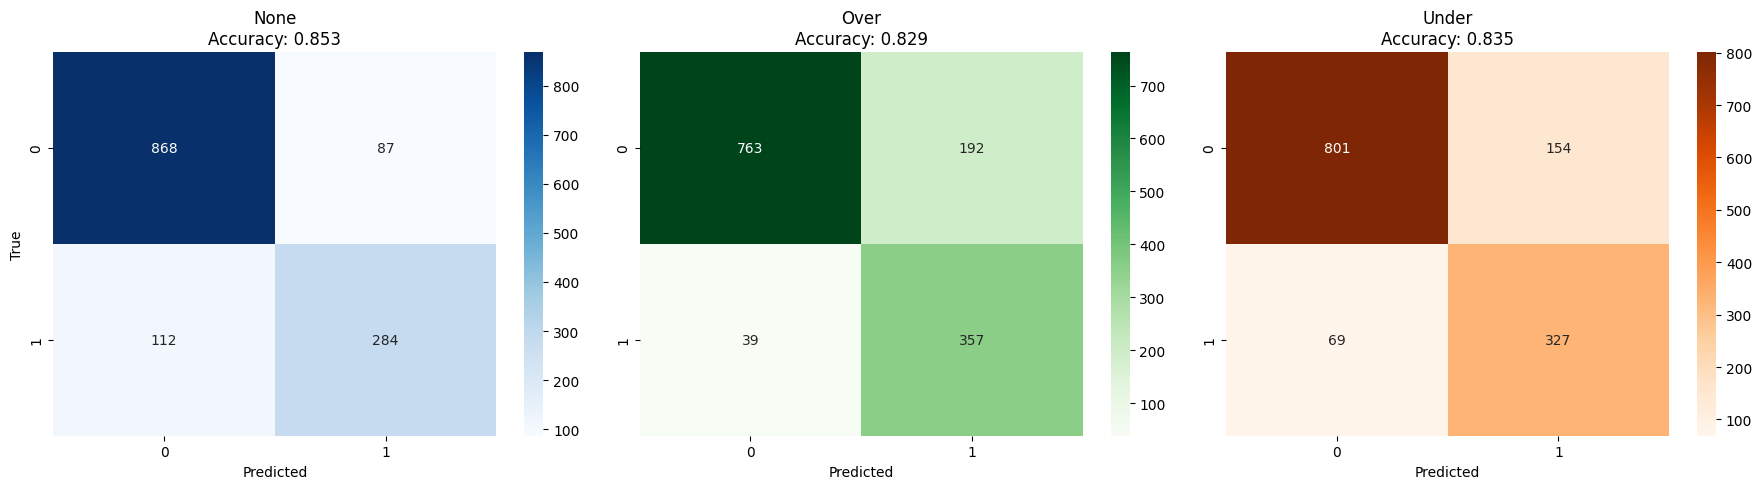

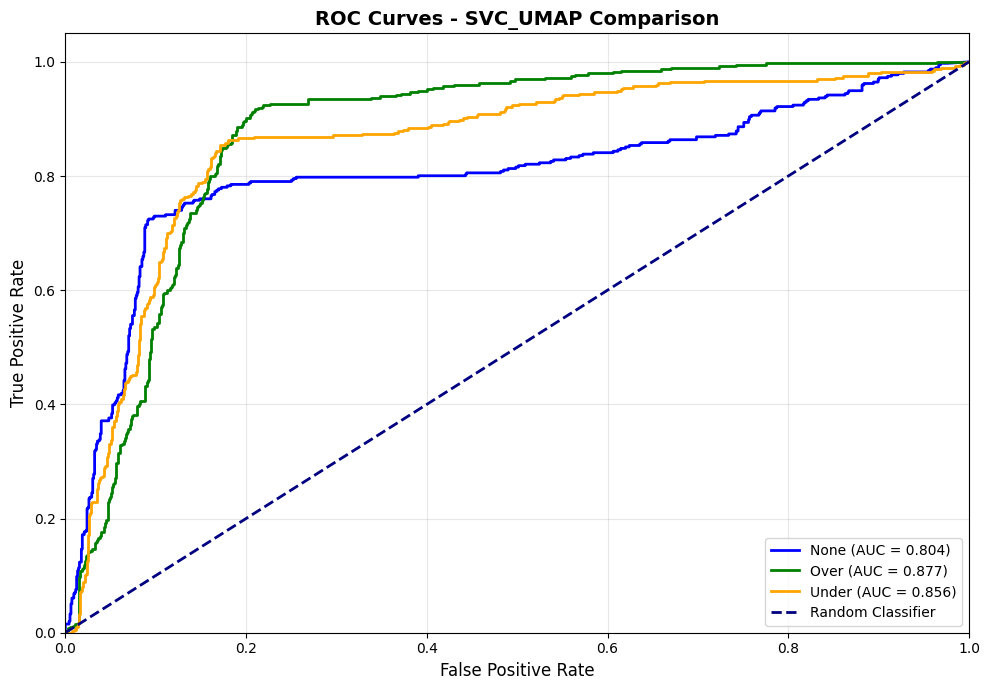

In [33]:
results_svc_umap = compute_results("SVC_UMAP", **configs)
render_plots("SVC_UMAP", results_svc_umap, colors)

### 3.2 Ensemble Machine Learning 

#### 3.2.2 RandomForest

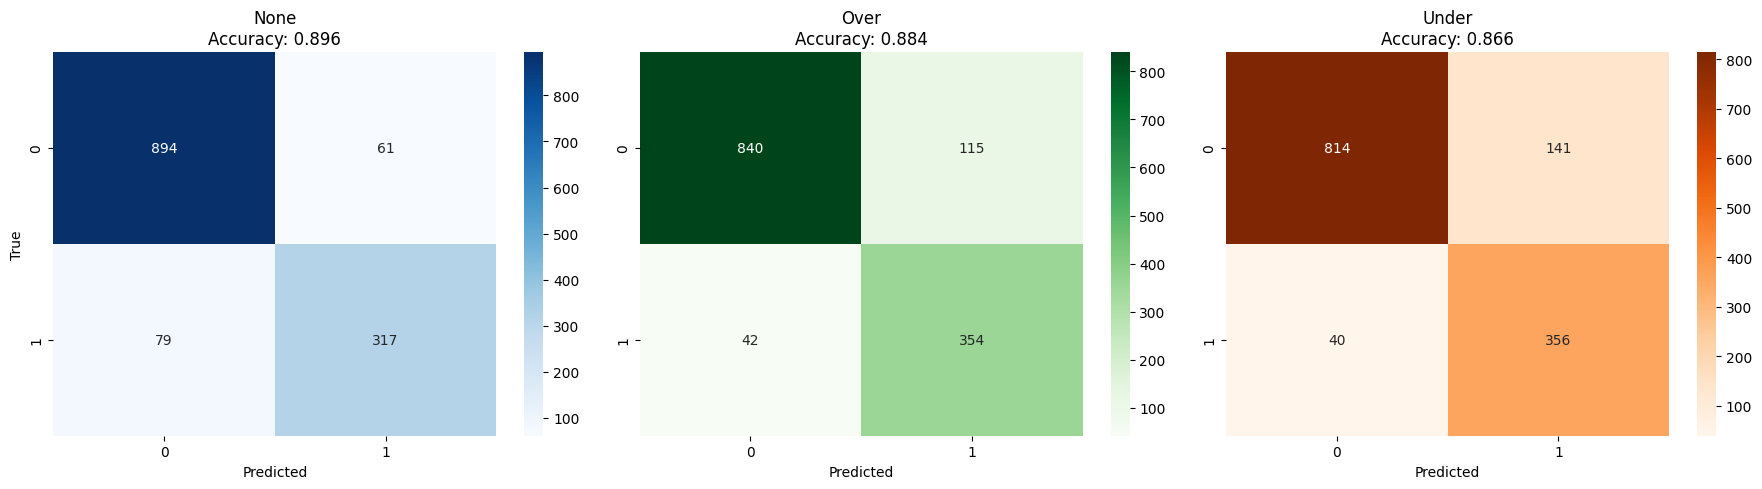

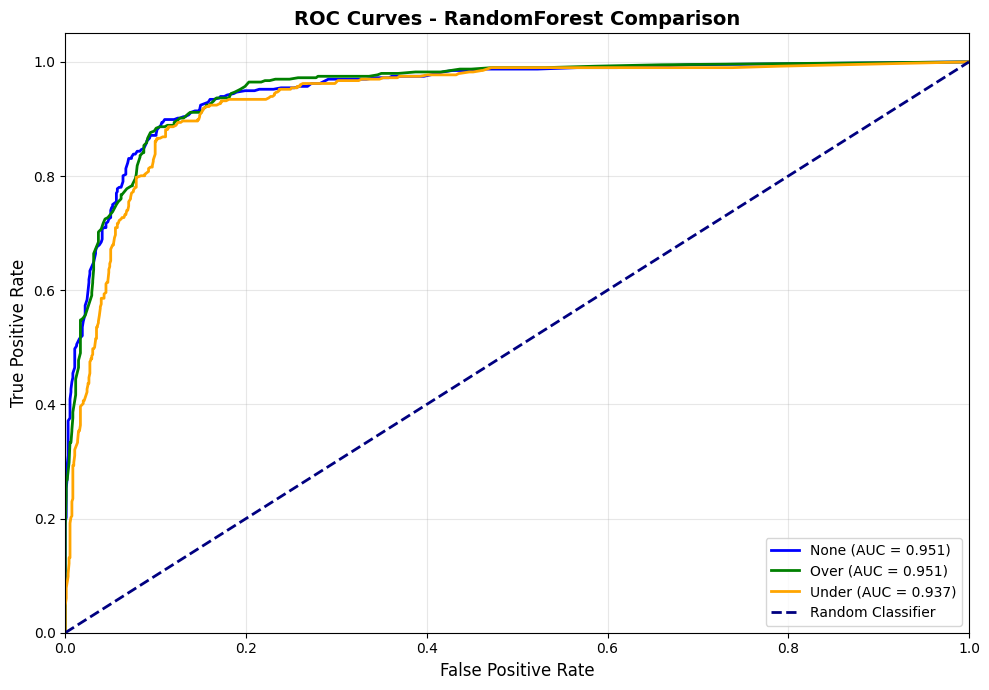

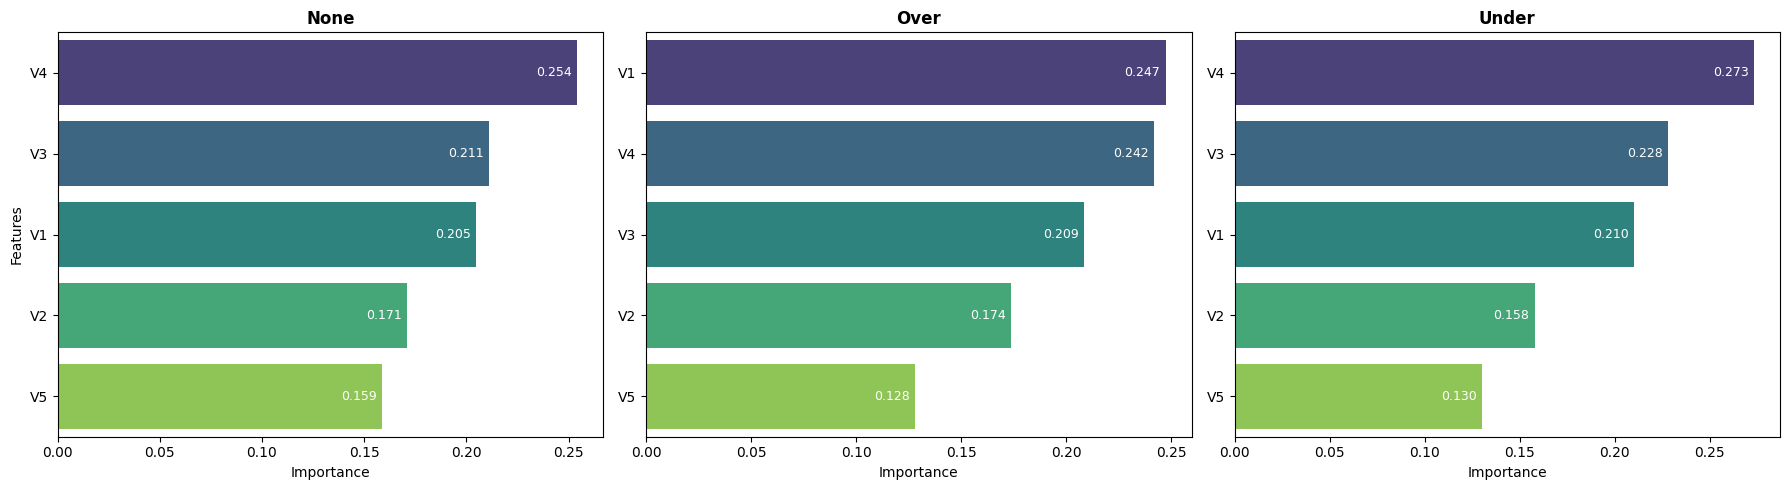

In [34]:
results = compute_results("RandomForest", **configs)
render_plots("RandomForest", results, colors)

#### 3.2.2 AdaBoost

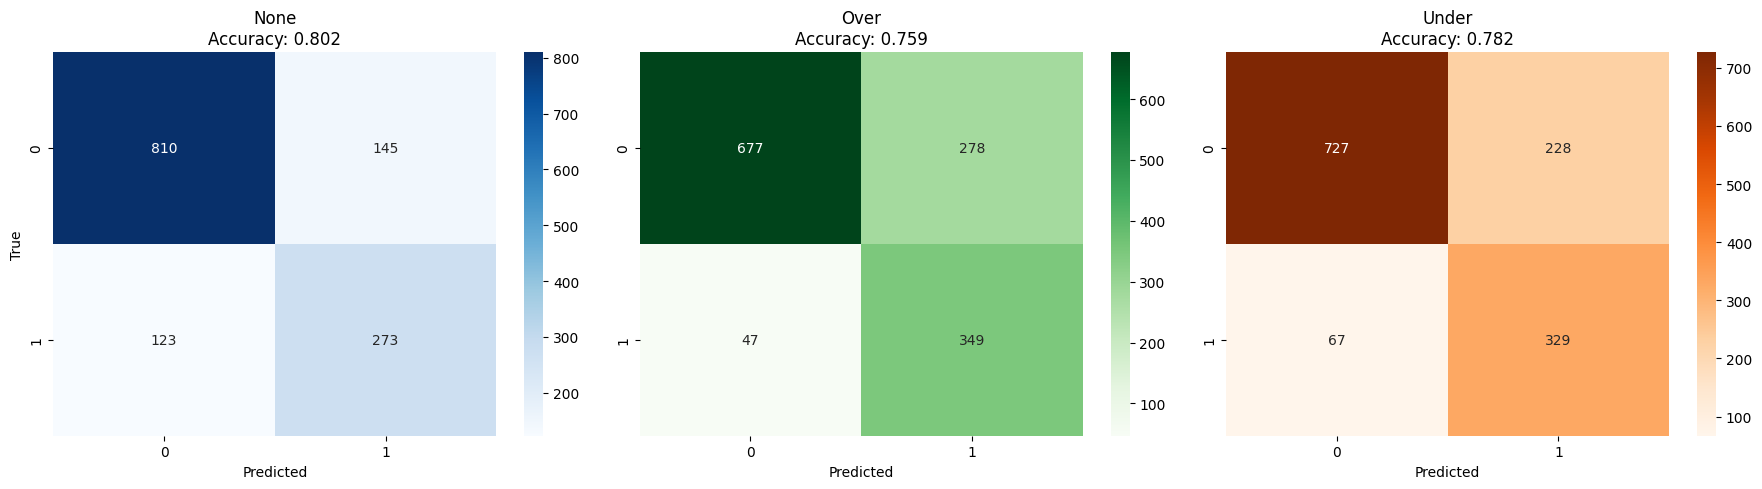

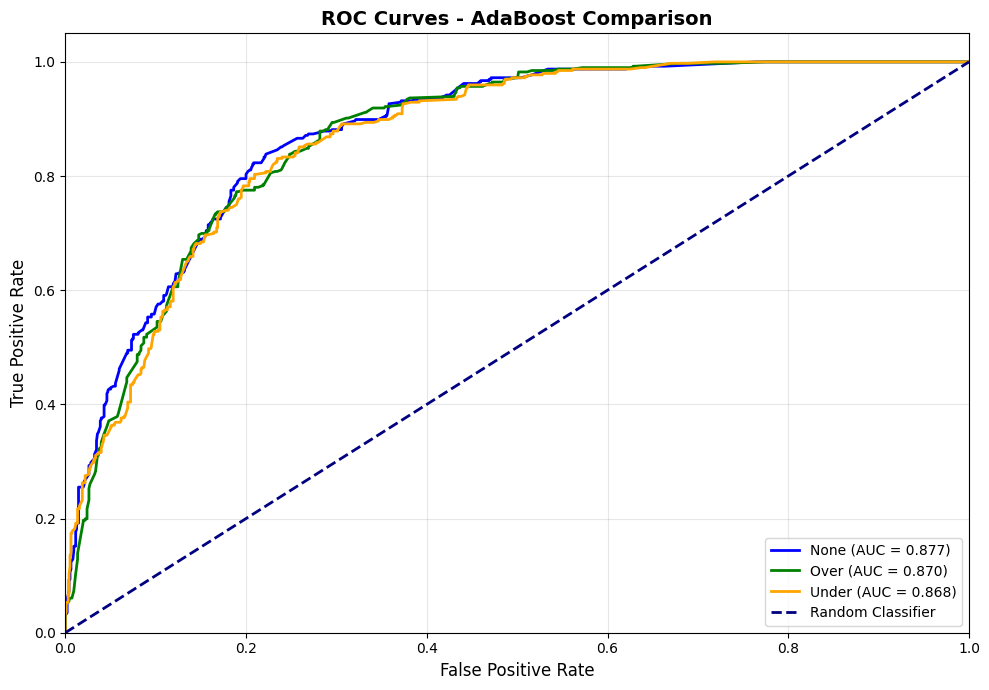

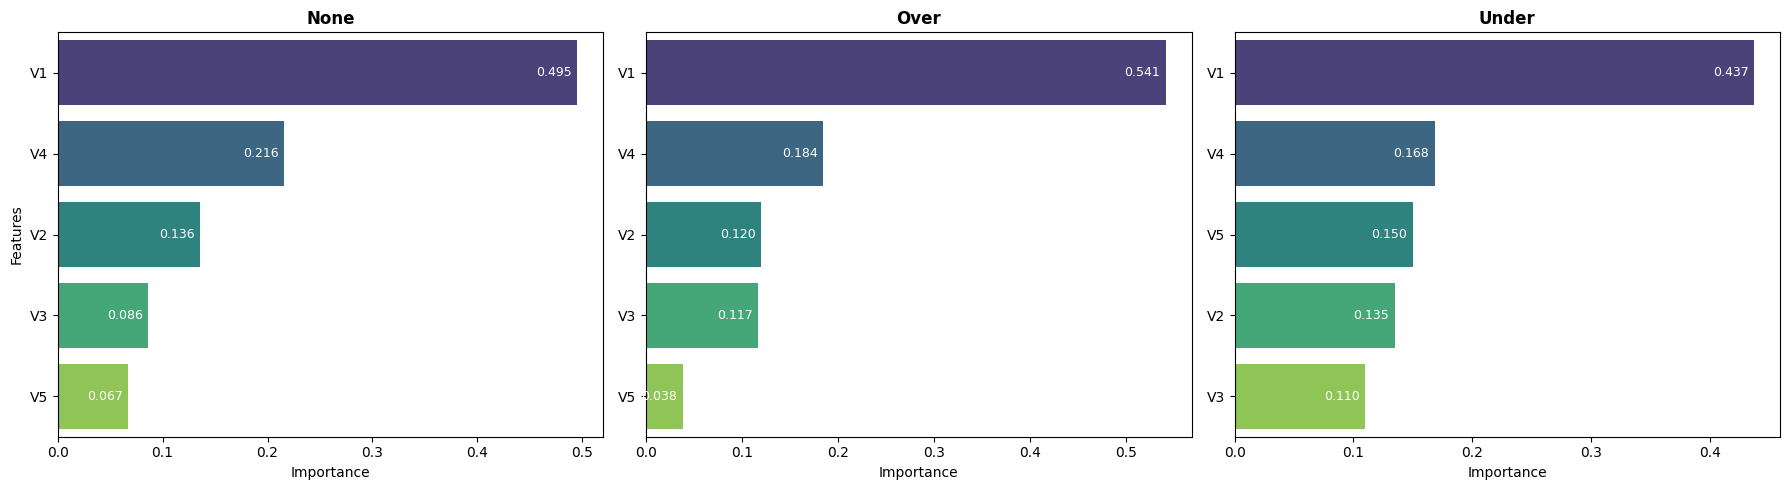

In [35]:
results = compute_results("AdaBoost", **configs)
render_plots("AdaBoost", results, colors)

#### 3.2.3 Extreme Gradient Boosting

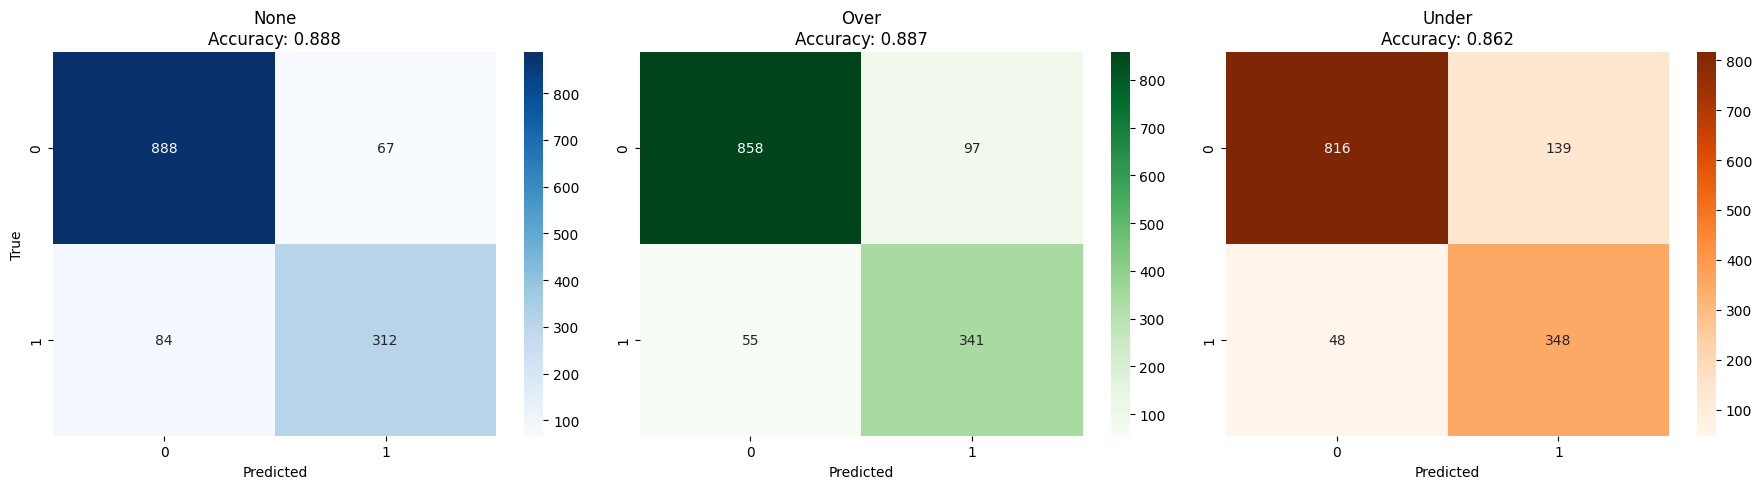

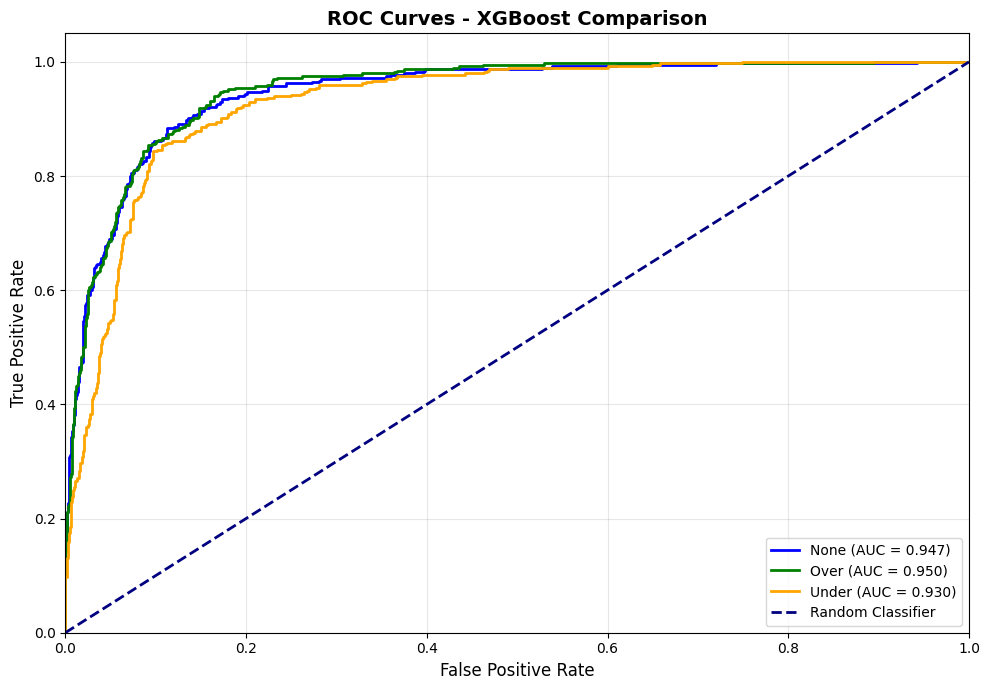

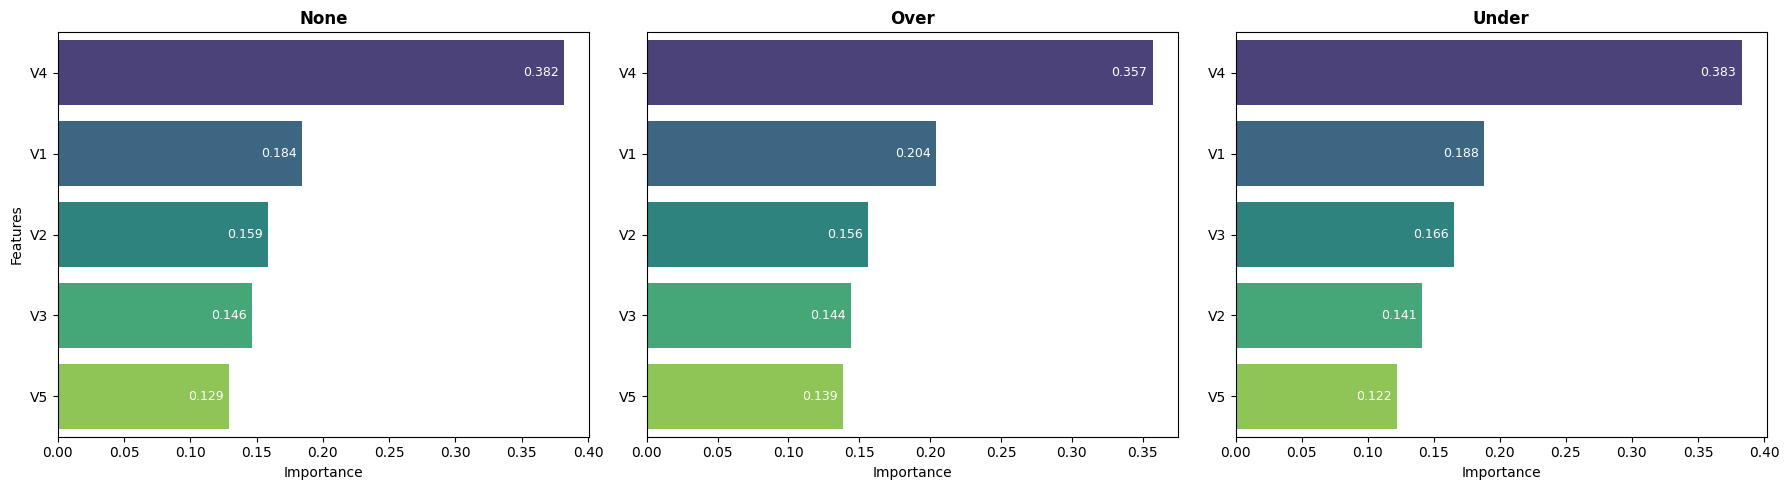

In [36]:
results = compute_results("XGBoost", **configs)
render_plots("XGBoost", results, colors)

#### 3.2.4 Custom Ensemble

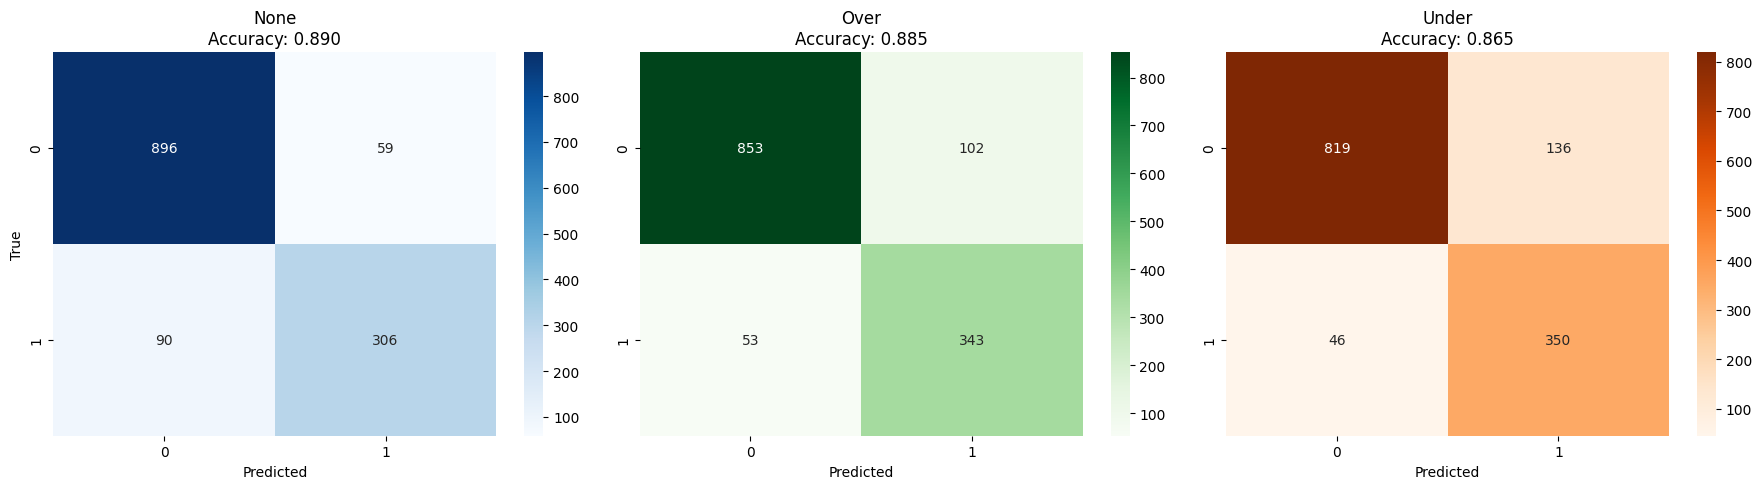

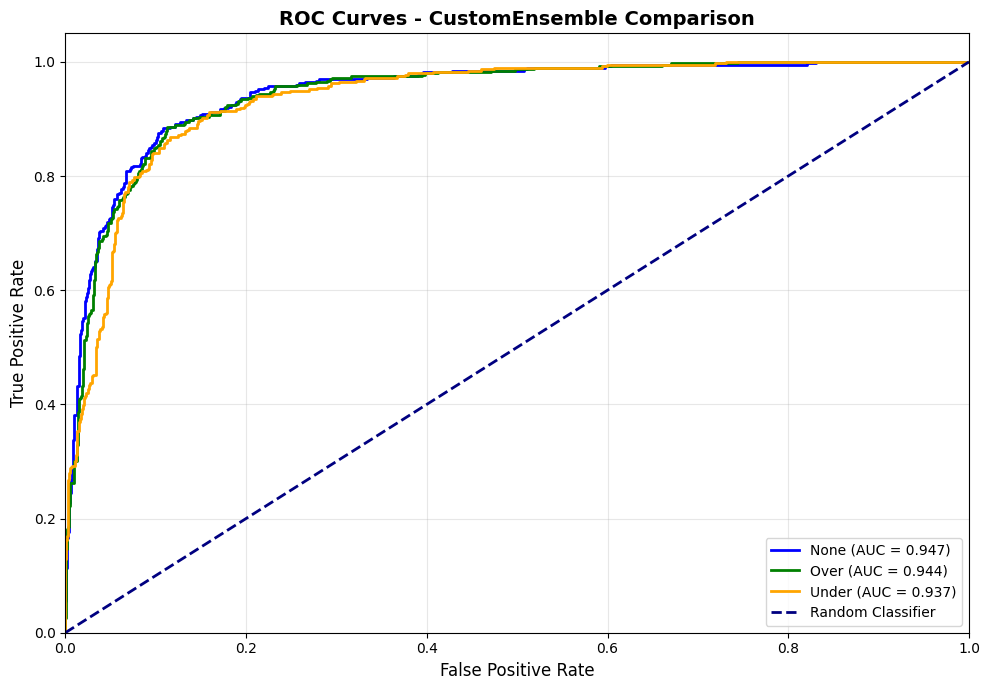

In [37]:
results = compute_results("CustomEnsemble", **configs)
render_plots("CustomEnsemble", results, colors)

### 3.3 Deep Learning

#### 3.3.1 Multi Layer Perceptron

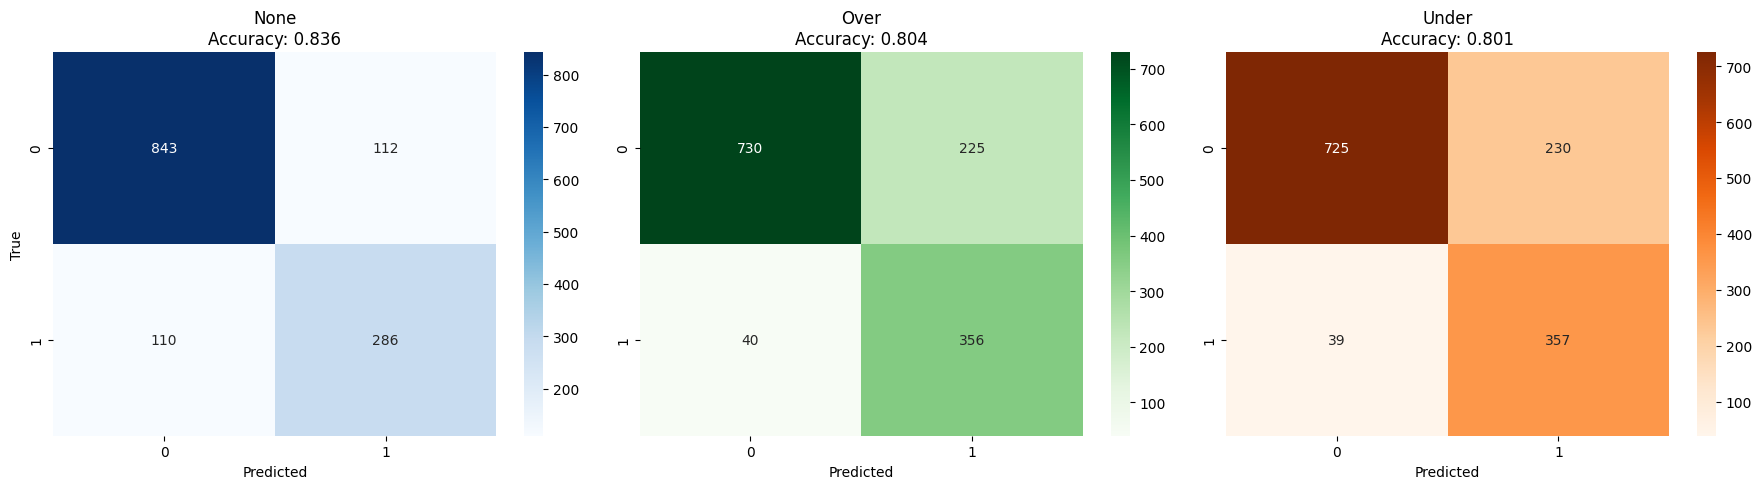

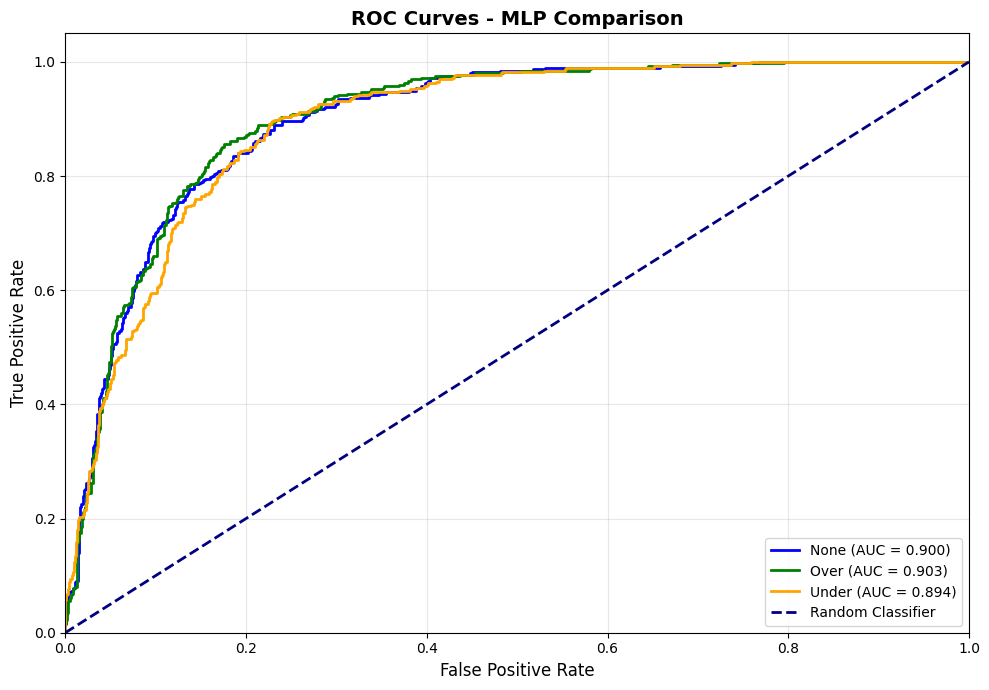

In [38]:
results = compute_results("MLP", **configs)
render_plots("MLP", results, colors)

#### 3.3.2 Convolutional Neural Network

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


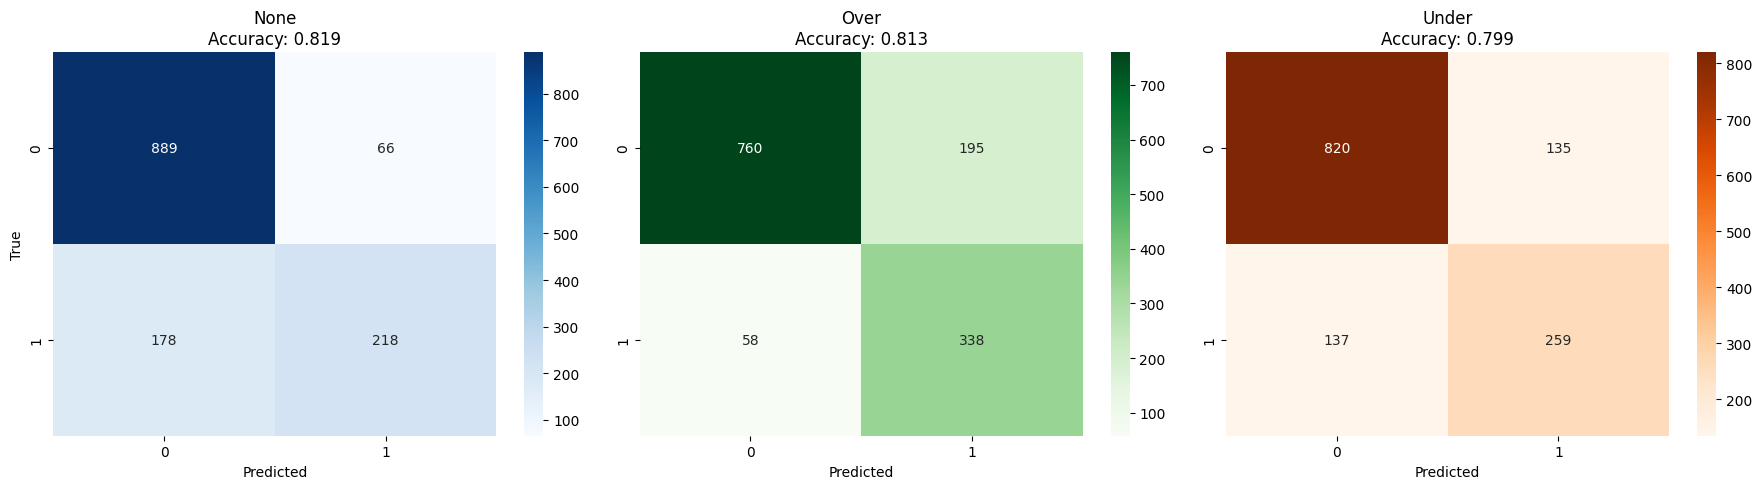

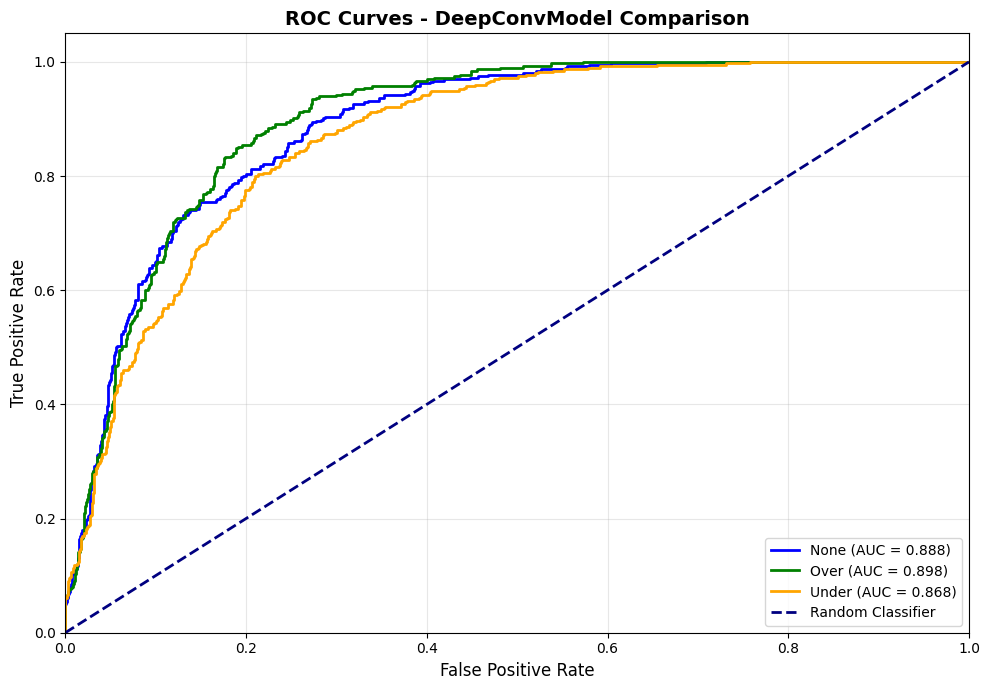

In [39]:
results = compute_results("DeepConvModel", **configs)
render_plots("DeepConvModel", results, colors)

## 4. Evaluation

In this section we will compare the performances of our models and draw conclusions about those which best performed for the phoneme classification and the effectiveness of balancing techniques.

❓ Our analysis will be guided by two research questions that we will try to address, they are the following:
- **RQ1**: Which of the models we use is the best on performing the task of phoneme classification?
- **RQ2**: Has the data balancing a positive impact on the performances?

Ideally, providing answers to these questions will give us the best possible approach, in terms of model selection and processing setup, to face the phoneme classification problem.

As first step, we collect the data about the performances of each models. These insight has been produced and saved in JSON files when, in the previous section, we tested the models.

Particularly to address RQ2, from now on, we will also consider the model performance both from a general point of view and from a perspective on the single class. It's useful to remember that class 0 (nasal sounds) is the most frequent one while class 1 (oral sounds) represent only the 30% of data.

In [41]:
evaluation_results = []
class_0_results = []
class_1_results = []

models_to_evaluate = [
    "DecisionTree", "NaiveBayes", "KNN", "SVC", "MLP", 
    "RandomForest", "AdaBoost", "XGBoost", "CustomEnsemble", "DeepConvModel", "SVC_PCA", "SVC_UMAP"
]

for model_name in models_to_evaluate:
    for strategy in ("none", "under", "over"):
        with open(f"results/{model_name}_{strategy}.json", mode="r") as file:
            metrics = dict(json.load(file))
            evaluation_results.append({
				"Model": model_name,
				"Strategy": strategy,
				"accuracy": metrics["accuracy"],
				"weighted_precision": metrics["weighted avg"]["precision"],
				"weighted_recall": metrics["weighted avg"]["recall"],
				"weighted_F1": metrics["weighted avg"]["f1-score"],
				"ROC-AUC": metrics["ROC-AUC"]
			})

            class_0_results.append({
				"Model": model_name,
				"Strategy": strategy,
				"precision [C0]": metrics["0"]["precision"],
				"recall [C0]": metrics["0"]["recall"],
				"F1 [C0]": metrics["0"]["f1-score"],
			})
            
            class_1_results.append({
				"Model": model_name,
				"Strategy": strategy,
				"precision [C1]": metrics["1"]["precision"],
				"recall [C1]": metrics["1"]["recall"],
				"F1 [C1]": metrics["1"]["f1-score"],
			})

#  DataFrame sorted by ROC-AUC
evaluation_df = pd.DataFrame(evaluation_results).sort_values(
    ["weighted_F1", "ROC-AUC"], ascending=[False, False]
).reset_index(drop=True)
class_0_df = pd.DataFrame(class_0_results).reset_index(drop=True).sort_values(
    ["F1 [C0]"], ascending=[False]
).reset_index(drop=True)
class_1_df = pd.DataFrame(class_1_results).reset_index(drop=True).sort_values(
    ["F1 [C1]"], ascending=[False]
).reset_index(drop=True)

evaluation_df.to_csv("data/model_evaluation_summary.csv", index=False)
class_0_df.to_csv("data/class_0_evaluation_summary.csv", index=False)
class_1_df.to_csv("data/class_1_evaluation_summary.csv", index=False)

📋 We create a dataframe containing for each model and for each sampling strategy the accuracy, ROC-AUC score and the precision, recall and F1-score weighted by class support (after oversampling and undersampling the classes are balanced in the train set but imbalanced in the test set due to how we set the `stratify` argument in the `train_test_split`).

In [42]:
# visualize the evaluation dataframe
evaluation_df.head()

Model Strategy  accuracy  weighted_precision  weighted_recall  \
0    RandomForest     none  0.896373            0.895305         0.896373   
1         XGBoost     over  0.887491            0.892503         0.887491   
2  CustomEnsemble     none  0.889711            0.888097         0.889711   
3             KNN     none  0.889711            0.888058         0.889711   
4         XGBoost     none  0.888231            0.887094         0.888231   

   weighted_F1   ROC-AUC  
0     0.895652  0.950553  
1     0.889059  0.949751  
2     0.888346  0.946837  
3     0.888250  0.854735  
4     0.887498  0.946623

Then we create a dataframe containing precision, recall and f1-score for class 0...

In [43]:
class_0_df.head()

Model Strategy  precision [C0]  recall [C0]   F1 [C0]
0    RandomForest     none        0.918808     0.936126  0.927386
1             KNN     none        0.907895     0.939267  0.923314
2  CustomEnsemble     none        0.908722     0.938220  0.923235
3         XGBoost     none        0.913580     0.929843  0.921640
4         XGBoost     over        0.939759     0.898429  0.918630

... and another one with the same metrics for class 1.

These two least datasets allow us to see the differences in performances with the two classes. 

We expect that these differences will be mitigated by the model trained with resampling techniques

In [44]:
class_1_df.head()

Model Strategy  precision [C1]  recall [C1]   F1 [C1]
0    RandomForest     none        0.838624     0.800505  0.819121
1    RandomForest     over        0.754797     0.893939  0.818497
2         XGBoost     over        0.778539     0.861111  0.817746
3  CustomEnsemble     over        0.770787     0.866162  0.815696
4         XGBoost     none        0.823219     0.787879  0.805161

In [46]:
# Pivot table for better visualization showing only accuracy
accuracy_pivot = evaluation_df.pivot(index="Model", columns="Strategy", values="weighted_F1").sort_values(["none", "under", "over"], ascending=[False, False, False]).round(4)
accuracy_pivot_mean = evaluation_df.pivot(index="Model", columns="Strategy", values="accuracy").mean(axis=1).sort_values(ascending=False).round(4)

In [47]:
accuracy_pivot.head()

Strategy          none    over   under
Model                                 
RandomForest    0.8957  0.8864  0.8699
CustomEnsemble  0.8883  0.8871  0.8688
KNN             0.8883  0.8842  0.8444
XGBoost         0.8875  0.8891  0.8653
SVC             0.8744  0.8539  0.8594

The following table is obtained by averaging, for each model, the performances with no balancing, undersampling and oversampling and highlights that ensemble models are best both than shallow and than deep models like MLP and DeepConvModel.

In [49]:
accuracy_pivot_mean.head()

Model
RandomForest      0.8821
CustomEnsemble    0.8801
XGBoost           0.8791
KNN               0.8712
SVC               0.8611
dtype: float64


📊 To address RQ2 we need to measure the performance gap between the case without rebalancing and the cases with oversampling and undersampling.

We chose to compare the distributions of model performances (each model's F1-score is an observation) and measure mean difference and statistical significance.

To have a clear idea of the model performance conditioned to the sampling strategy, we plot three grouped bar plots, one for each sampling strategy, where each bar plot is referred to a model and shows:

- In <span style="color:#FD0505;">RED</span> the overall F1-score weighted for class support
- In <span style="color:#04B3CE;">CYAN</span> the F1-score for datapoints in class 0
- In <span style="color:#018c3f;">GREEN</span> the F1-score for datapoints in class 1

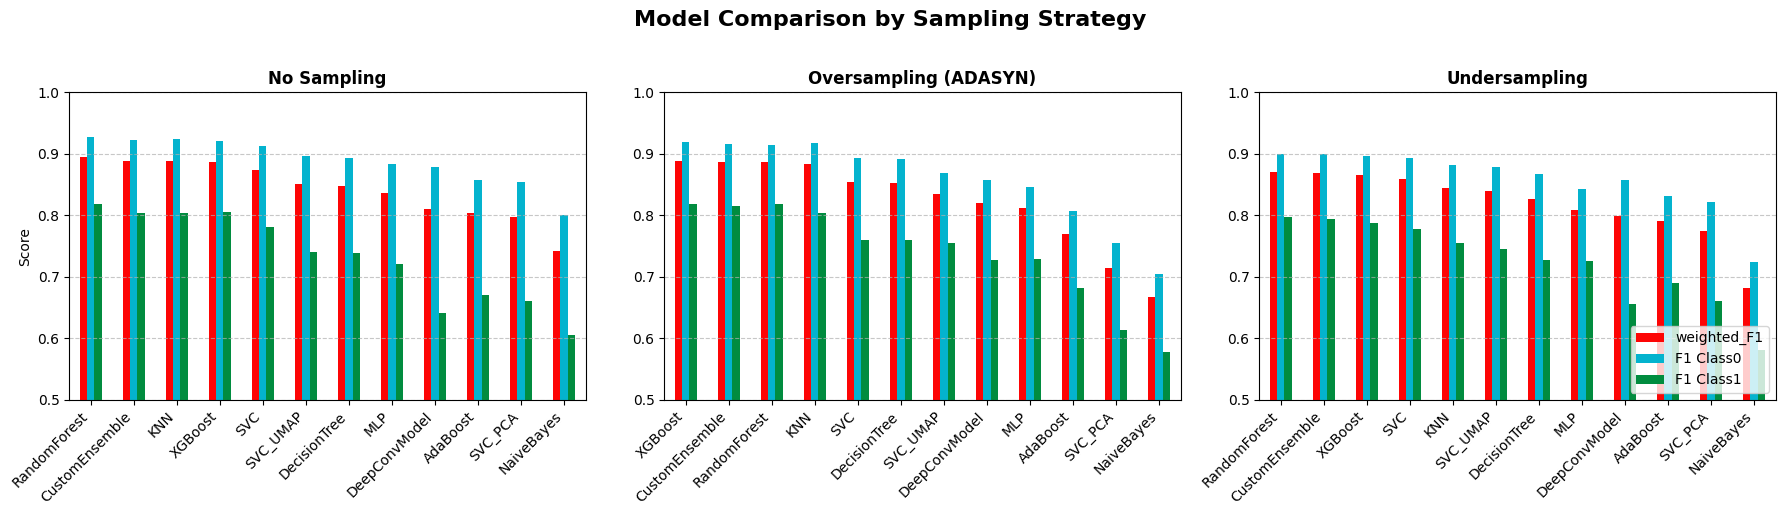

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Comparison by Sampling Strategy', fontsize=16, fontweight='bold', y=1.02)

strategies = ['none', 'over', 'under']
strategy_titles = {'none': 'No Sampling', 'over': 'Oversampling (ADASYN)', 'under': 'Undersampling'}
sampling_performances = {}

for idx, strategy in enumerate(strategies):
    ax = axes[idx]
    
    df_strategy = evaluation_df[evaluation_df["Strategy"] == strategy].copy()
    df_strategy = df_strategy.set_index("Model")[["weighted_F1"]]
    
    df_class0 = class_0_df[class_0_df["Strategy"] == strategy].set_index("Model")[["F1 [C0]"]]
    df_class1 = class_1_df[class_1_df["Strategy"] == strategy].set_index("Model")[["F1 [C1]"]]

    df_class0.columns = ["F1 Class0"]
    df_class1.columns = ["F1 Class1"]

    df_strategy = pd.concat([df_strategy, df_class0, df_class1], axis=1)
    sampling_performances[strategy] = df_strategy

    df_strategy.plot.bar(ax=ax, legend=False, color=["#FD0505", "#04B3CE", "#018c3f"])
    
    ax.set_title(strategy_titles[strategy], fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Score' if idx == 0 else '')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.5, 1.0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # legend solo nell'ultimo plot
    if idx == 2:
        ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


🔔 The following plot represents three KDE plots, each with three lines. Each line represents a distribution of performances where each model F1-score is an observation, in particular:
- In the first plot, each line represents the weighted F1-score for each of the three sampling strategies
- In the second plot, each line represents the weighted F1-score of class 0 for each of the three sampling strategies
- In the first plot, each line represents the weighted F1-score of class 1 for each of the three sampling strategies

The plots highlight that there is no evident difference between the performances with sampling and without sampling, but the first ones are, on average, always better. This observation will be supported by quantitative measuring in the continuous of the notebook.

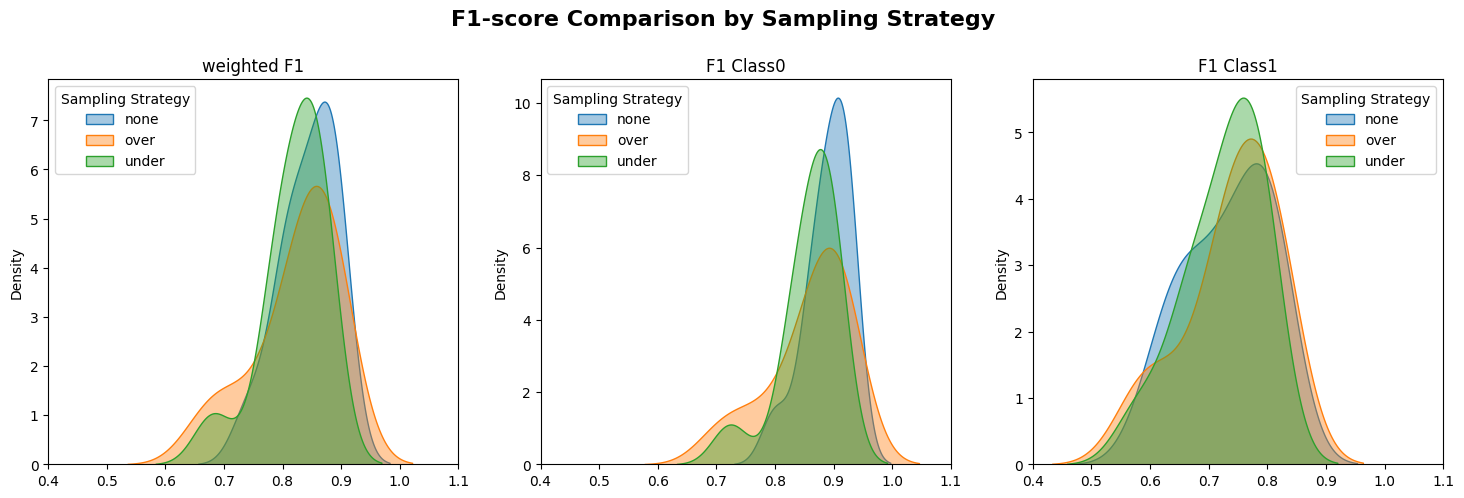

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('F1-score Comparison by Sampling Strategy', fontsize=16, fontweight='bold', y=1.02)

performance_change = {}

for i, evaluation in enumerate(("weighted_F1", "F1 Class0", "F1 Class1")):
	performance_change[evaluation] = {}
	none_performance = sampling_performances["none"][evaluation]
	for strategy, dataframe in sampling_performances.items():
		strategy_performance = sampling_performances[strategy][evaluation]
		t_stat, p_value = ttest_ind(none_performance, strategy_performance, equal_var=True)
		if strategy != "none":
			performance_change[evaluation][strategy] = f"Δ = {float((1 - none_performance.mean() / strategy_performance.mean()) * 100).__round__(2)}%, p = {float(p_value).__round__(2)}"

		sns.kdeplot(
			dataframe[evaluation].values,
			ax=axes[i],
			fill=True,
			alpha=0.4,
			label=strategy,
			palette="tab10"
		)

	axes[i].set_xbound((0.4, 1.1))
	axes[i].set_title(evaluation.replace("_", " "))
	axes[i].legend(title="Sampling Strategy")

performance_change_df = pd.DataFrame(performance_change)

### 4.1 RQ1: Performance comparison on phoneme classification
In this section we draw conclusions about how the models we tested perform in the phoneme dataset.

#### 4.1.1 Ensemble and Three-Based models dominate

🌲 **RandomForest**, **CustomEnsemble**, and **XGBoost** consistently outperform other models across all sampling strategies. Their robustness can be explained by:

- **Ensemble averaging** reduces variance and mitigates the impact of noisy samples
- **Tree-based methods** are inherently less sensitive to class imbalance due to their recursive partitioning approach
- These models effectively capture non-linear relationships and feature interactions present in the phoneme data

| Model           | weighted F1-score (*)   |
|----------------|---------|
| RandomForest   | 0.8821  |
| CustomEnsemble | 0.8801  |
| XGBoost        | 0.8791  |
| KNN            | 0.8712  |
| SVC            | 0.8611  |
| DecisionTree   | 0.8399  |
| SVC_UMAP       | 0.8389  |
| MLP            | 0.8135  |
| DeepConvModel  | 0.8103  |
| AdaBoost       | 0.7809  |
| SVC_PCA        | 0.7540  |
| NaiveBayes     | 0.6844  |

(*) averaged across the three sampling strategies

Also KNN showed a good performance, we explain this with considering the density of data; it is known and reasonable that distance-based models have better performance when datapoints belonging to the same class are near and their distribution is uniform, and this is the case of our data as can be observed in the PCA plot.


#### 4.1.2 Dimensionality reduction outperforms

⏬ The table below highlights a underperformance of the SVC trained on data reduced with PCA and UMAP. We suppose that this happens because our data has already low dimensionality, only 5 features, so the models manage to process it even without reduction; PCA and UMAP necessarily cause lose of useful information leading to worse performance.

| Model | weighted F1-score | Comparison |
|-------|----------|------------|
| SVC_PCA (2D) | 0.7540 | -14.20% vs SVC baseline |
| SVC_UMAP (2D) | 0.8389 | -2.65% vs SVC baseline |

**Key insights:**
- **PCA** loses precision and recall due to its linear nature, which fails to preserve complex non-linear relationships in the data
- **UMAP** nearly matches the full-dimensional SVC performance, demonstrating its superior ability to preserve both local and global data structure

#### 4.1.3 Deep models underperform

🕸️ Our test lead to a conclusion that we initially did not expect: deep models have lower performances not only compared to ensemble models, that are known to be robust and accurate, but also compared to shallow models like SVC or the decision tree. Some possibile explanation for this are the following:
- Data is tabular, well structured and engineered, a perfect setup for traditional models. Deep Learning shows the gap and becomes essential when data is unstructured and featues need to be learned by the model.
- Having only about 4000 datapoints for training, and a very high number of parameters, the poor performance of deep models can be due to underfit; in other words, the deep models did not see a sufficient number of train example to have a good generalization capability.
- While we tuned the hyperparameters for shallow models, we built deep ones, especially CNN, without an exaustive study to optimize the architecture, the optimizer, the number of epochs, the number of parameters and other crucual aspects that have a significative impact in the performance.

### 4.2 RQ2: The no-sampling stragegy performs Best

🗳️ Contrary to initial expectations, on average, models achieve their best performance without any sampling strategy applied. This finding suggests that:

- The class imbalance in this dataset is not severe enough to significantly impact model performance
- Most models are inherently capable of handling the natural, moderate imbalance present in the data
- Artificial resampling may introduce noise or distort the original data distribution, leading to suboptimal generalization

The following table shows the differencial (Δ) in average F1-score of the models when performing undersampling and oversampling compared to the case of no sampling.

What we can observe is that there is almost always a performance drop when sampling, except in one case: it seems that oversampling has a positive impact on the performance for class 1 (the less represented) but this difference is not significative so it can be due to randomness.

|        | weighted F1            | F1 (class0)             | F1 (class1)            |
|--------|------------------------|-----------------------|----------------------|
| **over**  | Δ = -2.55%, p = 0.41   | Δ = -3.75%, p = 0.17 | Δ = 0.80%, p = 0.85  |
| **under** | Δ = -3.01%, p = 0.25 | Δ = -3.70%, p = 0.09 | Δ = -1.02%, p = 0.80 |


This degradation can have different causes:
- For oversampling
	- **ADASYN** generating synthetic samples that may not accurately represent the true data distribution
	- Models overfitting to artificially created patterns in the minority class
	- The introduction of noise in the decision boundaries, particularly affecting distance-based and probabilistic models
- For undersampling
	- The removal of samples causes the loose of valuable patterns that can be detected by the models
	- The dataset variance increases because the datapoints are more sparse, so models' predictions are less stable

📝 Summing up our findings, the analysis reveals that for the phoneme classification task:

1. **Best approach**: Use ensemble methods (RandomForest, XGBoost) without sampling modifications
2. **Avoid**: Oversampling and undersampling
3. **For dimensionality reduction**: Prefer UMAP over PCA for representation but don't apply feature extraction for training